In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.errors import InvalidArgumentError
import tensorflow as tf


# Tensorflow GPU settings
# gpu_options = tf.GPUOptions(allow_growth=True)#per_process_gpu_memory_fraction=0.5)
# sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils import shuffle

from scipy import interpolate

import keras_tuner as kt
import sys

2022-03-03 06:10:43.059523: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-03-03 06:10:43.869816: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-03 06:10:43.870884: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-03-03 06:10:43.892826: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 4000 computeCapability: 7.5
coreClock: 1.545GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 387.49GiB/s
2022-03-03 06:10:43.892850: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-03-03 06:10:43.894362: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-0

Define functions

In [2]:
def yield_and_error(df):
    '''
    input: 
    df  : dataframe
    
    output:
    yield (significance, error)
    '''
    Y  = -1
    dY = -1
    Y  = sum(df.wgt)
    dY = np.sqrt(sum(df.wgt**2))
    # return tuple
    return Y, dY


def significance_and_error(S, dS, B, dB):
    '''
    input: 
    S  : signal
    dS : signal error
    B  : background
    dB : background error
    
    output:
    tuple (significance, error)
    '''
    # FAKE SIGNIFICANCE
#     significance = S/np.sqrt(B)
#     error        = np.sqrt( 1/B*(dS**2) + (S**2)/(4*B**3)*(dB**2) )
#     return significance, error
    
    # REAL SIGNIFICANCE
    # if a quantity is negative, return 0
    if (S<=0 or B<=0):
        return 0, 0
#     S = np.abs(S)
#     B = np.abs(B)
    # calculate the significance and its error
    significance = np.sqrt( 2*((S + B)*np.log(1 + S/B) - S) )
    dSignifdS    = np.log(1 + S/B)/significance
    dSignifdB    = ( np.log(1 + S/B) - S/B )/significance
    error        = np.sqrt( (dSignifdS*dS)**2 + (dSignifdB*dB)**2 )
    # return tuple
    return significance, error


def add_in_quadrature_3( XdX, YdY, ZdZ ):
    '''
    input: 
    XdX : tuple (significance, error)
    YdY : tuple (significance, error)
    ZdZ : tuple (significance, error)
    
    output:
    tuple (significance, error) added in quadrature
    '''
    # unpack the significances
    x, dx = XdX
    y, dy = YdY
    z, dz = ZdZ
    # calculate the addition in quadrature and its error
    quadrature_sum   = np.sqrt(x**2 + y**2 + z**2)
    A                = (x**2)*(dx**2) + (y**2)*(dy**2) + (z**2)*(dz**2)
    B                = (x**2) + (y**2) + (z**2)
    if (quadrature_sum==0):
        return 0, 0
    quadrature_error = np.sqrt( A / B )
    # return tuple
    return quadrature_sum, quadrature_error


def add_in_quadrature_n( my_inputs ):
    '''
    input: 
    a list of the type [XdX, YdY, ZdZ, etc.]
    where
    XdX : tuple (significance, error)
    YdY : tuple (significance, error)
    ZdZ : tuple (significance, error)
    
    output:
    tuple (significance, error) added in quadrature
    '''
    # unpack the significances
    values = np.array([])
    errors = np.array([])
    for i in range(len(my_inputs)):
        x, dx = my_inputs[i]
        values = np.append(values, x)
        errors = np.append(errors, dx)
    # calculate the addition in quadrature and its error
    quadrature_sum = np.sqrt(sum(values**2))
    
    A = sum((values**2)*(errors**2))
    B = sum(values**2)
    
#     quadrature_sum   = np.sqrt(x**2 + y**2 + z**2)
#     A                = (x**2)*(dx**2) + (y**2)*(dy**2) + (z**2)*(dz**2)
#     B                = (x**2) + (y**2) + (z**2)
    if (quadrature_sum==0):
        return 0, 0
    quadrature_error = np.sqrt( A / B )
    # return tuple
    return quadrature_sum, quadrature_error


def total_significance_and_error( df_sig, df_bg ):
    
    m_list = []
    for sr in [0,1,2]:
        S, dS = yield_and_error(df_sig[df_sig.SR == sr])
        B, dB = yield_and_error( df_bg[ df_bg.SR == sr])
        m_list.append(significance_and_error(S, dS, B, dB))
    significance, error = add_in_quadrature_3(m_list[0], m_list[1], m_list[2])
    return significance, error

def print_total_significance_and_error( df_sig, df_bg ):
    
    m_list = []
    for sr in [0,1,2]:
        S, dS = yield_and_error(df_sig[df_sig.SR == sr])
        print("--- S = {:.2f} ± {:.2f} ".format(S, dS))
        B, dB = yield_and_error( df_bg[ df_bg.SR == sr])
        print("--- B = {:.2f} ± {:.2f} ".format(B, dB))
        m_list.append(significance_and_error(S, dS, B, dB))
    significance, error = add_in_quadrature_3(m_list[0], m_list[1], m_list[2])
    print("SF-inZ significance = {:.2f} ± {:.2f} ".format(m_list[0][0], m_list[0][1]))
    print("SF-noZ significance = {:.2f} ± {:.2f} ".format(m_list[1][0], m_list[1][1]))
    print("DF significance     = {:.2f} ± {:.2f} ".format(m_list[2][0], m_list[2][1]))
    print("Total significance  = {:.2f} ± {:.2f} ".format(significance, error))


test

In [39]:
add_in_quadrature_3((0.90,0.04),(1.42,0.06),(2.30,0.01))

(2.8489296235603994, 0.03345475069395787)

In [4]:
add_in_quadrature_n([(1.2,0.1),(1.6,0.2),(2.4,0.2),(3.4,0.1)])

(4.6173585522460785, 0.14733403229794106)

# Real ML starts here

In [5]:
this_channel = '20220301_ELReLMIs54_MUReLMIs31_btag77'

sig = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/' + this_channel + '_VVZ_RD.arrow')
sig = sig[sig.SR == 0]
sig['is_signal'] = True
sig = sig.reset_index(drop=True)

bg = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/' + this_channel + '_FULLBG_RD.arrow')
bg = bg[bg.SR == 0]
bg['is_signal'] = False
bg = bg.reset_index(drop=True)

name = 'trained_in_SR0'

In [6]:
print(len(sig), len(bg))
print(sum(sig.wgt), sum(bg.wgt))

39782 781892
5.2633852617844346 1069.8244928420672


In [7]:
print_total_significance_and_error(sig, bg)

--- S = 5.26 ± 0.05 
--- B = 1069.82 ± 3.53 
--- S = 0.00 ± 0.00 
--- B = 0.00 ± 0.00 
--- S = 0.00 ± 0.00 
--- B = 0.00 ± 0.00 
SF-inZ significance = 0.16 ± 0.00 
SF-noZ significance = 0.00 ± 0.00 
DF significance     = 0.00 ± 0.00 
Total significance  = 0.16 ± 0.00 


In [8]:
sig.columns

Index(['index', 'Wlep1_phi', 'jet_eta_3', 'jet_btagCont_2', 'Zlep1_phi',
       'Wlep1_ambiguous', 'leptonic_HT', 'Zlep2_pt', 'jet_m_2', 'jet_pt_2',
       'lep4_ambiguous', 'METSig', 'jet_eta_4', 'jet_m_3', 'Zlep2_phi', 'MET',
       'other_mass', 'jet_m_4', 'Wlep2_pid', 'jet_eta_1', 'Wlep1_dphi',
       'Zlep1_pt', 'eta_3', 'eta_4', 'jet_pt_4', 'METPhi', 'wgt', 'jet_eta_2',
       'phi_4', 'v_j_btag70', 'phi_1', 'jet_btagCont_4', 'jet_phi_2',
       'jet_phi_3', 'Wlep2_ambiguous', 'Zlep1_dphi', 'Zlep1_pid', 'lep4_pid',
       'mass_4l', 'Zlep2_pid', 'pt_4l', 'lep1_ambiguous', 'SR', 'Wlep1_pt',
       'lep2_pid', 'Wlep1_pid', 'v_j_btag77', 'Wlep2_phi', 'chisq',
       'Zlep1_ambiguous', 'jet_pt_3', 'jet_m_1', 'eta_1', 'v_j_btag85',
       'jet_btagCont_3', 'total_HT', 'Zlep2_ambiguous', 'lep3_ambiguous',
       'Zlep1_eta', 'Zlep2_dphi', 'lep3_pid', 'jet_btagCont_1', 'HT', 'pt_2',
       'pt_4', 'pt_3', 'Wlep1_eta', 'Wlep2_dphi', 'phi_3', 'Zlep2_eta',
       'jet_pt_1', 'pt_1', 'jet_p

In [9]:

lep_dphi_cols = ['Zlep1_pt', 'Zlep1_eta', 'Zlep1_dphi', 
                 'Zlep2_pt', 'Zlep2_eta', 'Zlep2_dphi', 
                 'Wlep1_pt', 'Wlep1_eta', 'Wlep1_dphi', 
                 'Wlep2_pt', 'Wlep2_eta', 'Wlep2_dphi', 
                 'Zlep1_pid', 'Zlep2_pid', 'Wlep1_pid','Wlep2_pid', 
                 'pt_1', 'pt_2', 'pt_4', 'pt_3', 
                 'Zcand_mass', 'other_mass', 'mass_4l', 'pt_4l',
                 'leptonic_HT', 'HT',  'total_HT',   
                 'MET', 'METSig', 
                 'Njet',
                 'jet_pt_1', 'jet_pt_2', 'jet_pt_3', 'jet_pt_4',
                 'jet_eta_1', 'jet_eta_2', 'jet_eta_3', 'jet_eta_4',
                 'jet_m_1', 'jet_m_2', 'jet_m_3', 'jet_m_4',]

                 
# lep_dphi_cols = ['Zlep1_pt', 'Zlep1_eta' 'Zlep1_dphi', 
#                  'Zlep2_pt', 'Zlep2_eta' 'Zlep2_dphi', 
#                  'Wlep1_pt', 'Wlep1_eta' 'Wlep1_dphi', 
#                  'Wlep2_pt', 'Wlep2_eta' 'Wlep2_dphi', 
#                  'Zlep1_pid', 'Zlep2_pid', 'Wlep1_pid','Wlep2_pid', 
#                  'pt_1', 'pt_2', 'pt_4', 'pt_3', 
#                  'Zcand_mass', 'other_mass', 'mass_4l', 'pt_4l',
#                  'leptonic_HT', 'HT',  'total_HT',   
#                  'MET', 'METSig', 
#                  'Njet',
#                  'jet_pt_1', 'jet_pt_2', 'jet_pt_3', 'jet_pt_4',
#                  'jet_eta_1', 'jet_eta_2', 'jet_eta_3', 'jet_eta_4',
#                  'jet_m_1', 'jet_m_2', 'jet_m_3', 'jet_m_4',
#                  'jet_btagCont_1','jet_btagCont_2','jet_btagCont_3','jet_btagCont_4']

X = pd.concat([sig[lep_dphi_cols], bg[lep_dphi_cols]], ignore_index=True)

In [10]:
# Normalize inputs for NN training
min_max_scaler = preprocessing.MinMaxScaler()

min_max_scaler.fit(X)

for df in [sig, bg]:
    df[lep_dphi_cols] = min_max_scaler.transform(df[lep_dphi_cols])

In [11]:
sig['dummy_wgt'] = 1
bg['dummy_wgt']  = 1

In [12]:
# Split train and test data

# sig_train, sig_test = train_test_split(sig[lep_dphi_cols + ['wgt'] + ['SR']], train_size=0.5)
# bg_train, bg_test = train_test_split(bg[lep_dphi_cols + ['wgt'] + ['SR']], train_size=0.5)
sig_train, sig_test = train_test_split(sig[lep_dphi_cols + ['dummy_wgt'] + ['wgt'] + ['SR']], train_size=0.5)
bg_train,  bg_test  = train_test_split( bg[lep_dphi_cols + ['dummy_wgt'] + ['wgt'] + ['SR']], train_size=0.5)

n_sig = len(sig_train) # should be weighted?
n_bg = len(bg_train)

# weighted
n_sig = sum(sig_train['wgt']) 
n_bg = sum(bg_train['wgt'])

x_train = pd.concat([sig_train[lep_dphi_cols], bg_train[lep_dphi_cols]])
y_train = np.concatenate([np.ones(len(sig_train)), np.zeros(len(bg_train))]) # [1,1,...,0,0,...]
wgt_train = np.concatenate([sig_train['wgt'], bg_train['wgt']])
# Scaling the weight and dummy weights:
w_train = pd.Series(np.concatenate([(n_sig + n_bg) / n_sig * sig_train['wgt'], 
                                    (n_sig + n_bg) / n_bg  *  bg_train['wgt']]))
dummy_w_train = pd.Series(np.concatenate([(n_sig + n_bg) / n_sig * sig_train['dummy_wgt'], 
                                          (n_sig + n_bg) / n_bg  *  bg_train['dummy_wgt']]))
SR_train = np.concatenate([sig_train['SR'], bg_train['SR']])
# sklearn.utils import shuffle
x_train, y_train, wgt_train, w_train, dummy_w_train, SR_train = shuffle(x_train, y_train, wgt_train, w_train, dummy_w_train, SR_train)


n_sig = len(sig_test) 
n_bg = len(bg_test)

# weighted
n_sig = sum(sig_test['wgt']) 
n_bg = sum(bg_test['wgt'])


x_test = pd.concat([sig_test[lep_dphi_cols], bg_test[lep_dphi_cols]])
y_test = np.concatenate([np.ones(len(sig_test)), np.zeros(len(bg_test))])  # [1,1,...,0,0,...]
wgt_test = np.concatenate([sig_test['wgt'], bg_test['wgt']])
# Scaling the weight and dummy weights:
w_test = pd.Series(np.concatenate([(n_sig + n_bg) / n_sig * sig_test['wgt'], 
                                   (n_sig + n_bg) / n_bg  * bg_test['wgt']]))
dummy_w_test = pd.Series(np.concatenate([(n_sig + n_bg) / n_sig * sig_test['dummy_wgt'], 
                                         (n_sig + n_bg) / n_bg  *  bg_test['dummy_wgt']]))
SR_test = np.concatenate([sig_test['SR'], bg_test['SR']])


In [13]:
print(len(sig_train), len(bg_train), len(y_train), len(w_train))
print("Training sample")
print_total_significance_and_error(sig_train, bg_train)

19891 390946 410837 410837
Training sample
--- S = 2.61 ± 0.03 
--- B = 532.12 ± 2.57 
--- S = 0.00 ± 0.00 
--- B = 0.00 ± 0.00 
--- S = 0.00 ± 0.00 
--- B = 0.00 ± 0.00 
SF-inZ significance = 0.11 ± 0.00 
SF-noZ significance = 0.00 ± 0.00 
DF significance     = 0.00 ± 0.00 
Total significance  = 0.11 ± 0.00 


In [14]:
print(len(sig_test), len(bg_test), len(y_test), len(w_test))
print("Eval sample")
print_total_significance_and_error(sig_test, bg_test)

19891 390946 410837 410837
Eval sample
--- S = 2.65 ± 0.03 
--- B = 537.71 ± 2.42 
--- S = 0.00 ± 0.00 
--- B = 0.00 ± 0.00 
--- S = 0.00 ± 0.00 
--- B = 0.00 ± 0.00 
SF-inZ significance = 0.11 ± 0.00 
SF-noZ significance = 0.00 ± 0.00 
DF significance     = 0.00 ± 0.00 
Total significance  = 0.11 ± 0.00 


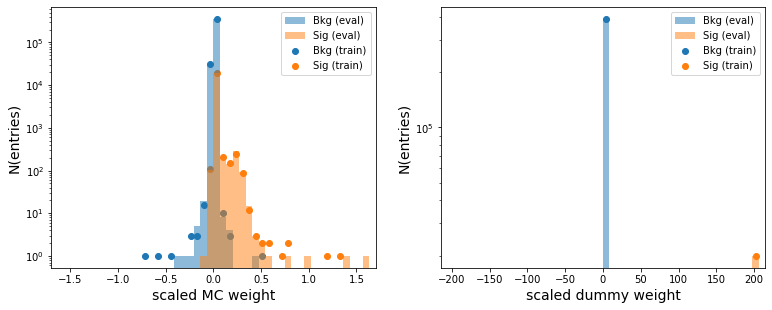

In [15]:
plt.figure(figsize=[2*6.4,1*4.8])

b = 50
ax = plt.subplot(1, 2, 1)
m = 1.05*np.max([np.max(abs(w_train)), np.max(abs(w_test))])
# plot test
_, b, _ = plt.hist(w_test[y_test==0], bins=b, alpha=0.5, range=(-m,m), label='Bkg (eval)')
_, b, _ = plt.hist(w_test[y_test==1], bins=b, alpha=0.5, range=(-m,m), label='Sig (eval)')
# plot train
bin_centers = (b[:-1]+b[1:])/2
w_train_bg  = np.histogram(w_train[y_train == 0], bins=b)[0]
w_train_sig = np.histogram(w_train[y_train == 1], bins=b)[0]
plt.scatter(bin_centers, w_train_bg,  label='Bkg (train)')
plt.scatter(bin_centers, w_train_sig, label='Sig (train)')
plt.xlim([-m,m])
plt.yscale('log')
plt.legend()
plt.xlabel('scaled MC weight', fontsize=14)
plt.ylabel('N(entries)', fontsize=14)

b = 50
ax = plt.subplot(1, 2, 2)
m = 1.05*np.max([np.max(abs(dummy_w_train)), np.max(abs(dummy_w_test))])
# plot test
_, b, _ = plt.hist(dummy_w_test[y_test==0], bins=b, alpha=0.5, range=(-m,m), label='Bkg (eval)')
_, b, _ = plt.hist(dummy_w_test[y_test==1], bins=b, alpha=0.5, range=(-m,m), label='Sig (eval)')
bin_centers = (b[:-1]+b[1:])/2
# plot train
dummy_w_train_bg  = np.histogram(dummy_w_train[y_train == 0], bins=b)[0]
dummy_w_train_sig = np.histogram(dummy_w_train[y_train == 1], bins=b)[0]
plt.scatter(bin_centers, dummy_w_train_bg,  label='Bkg (train)')
plt.scatter(bin_centers, dummy_w_train_sig, label='Sig (train)')
plt.xlim([-m,m])
plt.yscale('log')
plt.legend()
plt.xlabel('scaled dummy weight', fontsize=14)
plt.ylabel('N(entries)', fontsize=14)

plt.savefig('plots/scaled_weights_{}.pdf'.format(name))

plt.show()

Zoomed-in version of the normal MC weight, to see the substructure:

0.008348174604428743
0.00016696349208857487


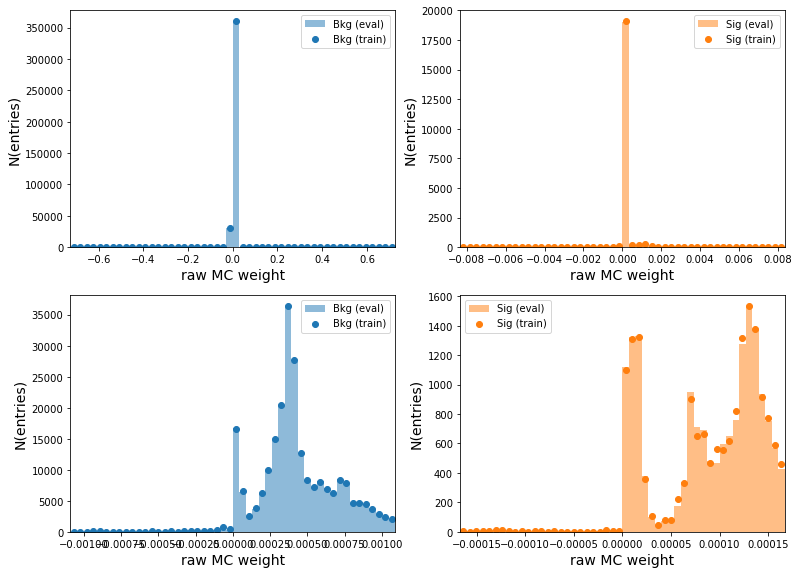

In [16]:
fig = plt.figure(figsize=[2*6.4,2*4.8])

b = 50
ax = plt.subplot(2, 2, 1)
m = 1.05*np.max([np.max(abs(wgt_train[y_train==0])), np.max(abs(wgt_test[y_test==0]))])
# plot test
_, b, _ = plt.hist(wgt_test[y_test==0], bins=b, alpha=0.5, range=(-m,m), label='Bkg (eval)')# plot train
bin_centers = (b[:-1]+b[1:])/2
wgt_train_bg  = np.histogram(wgt_train[y_train == 0], bins=b)[0]
plt.scatter(bin_centers, wgt_train_bg,  label='Bkg (train)')
plt.xlim([-m,m])
# plt.yscale('log')
plt.legend()
plt.xlabel('raw MC weight', fontsize=14)
plt.ylabel('N(entries)', fontsize=14)

b = 50
ax = plt.subplot(2, 2, 2)
m = 1.05*np.max([np.max(abs(wgt_train[y_train==1])), np.max(abs(wgt_test[y_test==1]))])
print(m)
# plot test
_, b, _ = plt.hist(wgt_test[y_test==1], bins=b, alpha=0.5, range=(-m,m), label='Sig (eval)', color='C1')
# plot train
bin_centers = (b[:-1]+b[1:])/2
wgt_train_sig = np.histogram(wgt_train[y_train == 1], bins=b)[0]
plt.scatter(bin_centers, wgt_train_sig, label='Sig (train)', color='C1')
plt.xlim([-m,m])
# plt.yscale('log')
plt.legend()
plt.xlabel('raw MC weight', fontsize=14)
plt.ylabel('N(entries)', fontsize=14)


b = 50
ax = plt.subplot(2, 2, 3)
m = 1.05*np.max([np.max(abs(wgt_train[y_train==0])), np.max(abs(wgt_test[y_test==0]))])*0.0015
# plot test
_, b, _ = plt.hist(wgt_test[y_test==0], bins=b, alpha=0.5, range=(-m,m), label='Bkg (eval)')# plot train
bin_centers = (b[:-1]+b[1:])/2
wgt_train_bg  = np.histogram(wgt_train[y_train == 0], bins=b)[0]
plt.scatter(bin_centers, wgt_train_bg,  label='Bkg (train)')
plt.xlim([-m,m])
# plt.yscale('log')
plt.legend()
plt.xlabel('raw MC weight', fontsize=14)
plt.ylabel('N(entries)', fontsize=14)

b = 50
ax = plt.subplot(2, 2, 4)
m = 1.05*np.max([np.max(abs(wgt_train[y_train==1])), np.max(abs(wgt_test[y_test==1]))])*0.02
print(m)
# plot test
_, b, _ = plt.hist(wgt_test[y_test==1], bins=b, alpha=0.5, range=(-m,m), label='Sig (eval)', color='C1')
# plot train
bin_centers = (b[:-1]+b[1:])/2
wgt_train_sig = np.histogram(wgt_train[y_train == 1], bins=b)[0]
plt.scatter(bin_centers, wgt_train_sig, label='Sig (train)', color='C1')
plt.xlim([-m,m])
# plt.yscale('log')
plt.legend()
plt.xlabel('raw MC weight', fontsize=14)
plt.ylabel('N(entries)', fontsize=14)

plt.savefig('plots/raw_weights_{}.pdf'.format(name))
plt.show()

# Fit ML classifier

In [ ]:
use_mc_weights = True
# use_mc_weights = False

# Chop off the negative weights?

Train and evaluate!

In [ ]:
# Fit ML classifier
EPOCHS = 10000
patience = 20
batch_size = 256
num_nodes = 64
dropout = 0.1
learn_rate = 1e-5

v_classifier = []
v_history = []

n_models = 10

x_test_results = x_test.copy()

for i in range(n_models):
    print("Running model", i)
    
    # Generate and fit model
    K.clear_session()

# Generate and fit model
    K.clear_session()
    classifier = Sequential()
    classifier.add(Dense(num_nodes, input_dim=x_train.shape[1], activation='relu')) 
    classifier.add(Dropout(dropout))
    classifier.add(Dense(num_nodes, activation='relu'))
    classifier.add(Dropout(dropout))
    classifier.add(Dense(num_nodes, activation='relu'))
    classifier.add(Dropout(dropout))
    classifier.add(Dense(1, activation='sigmoid'))

    opt = keras.optimizers.Adam(learning_rate=learn_rate)
    classifier.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    # Early stopping
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    if (use_mc_weights):
        history = classifier.fit(x_train, y_train, epochs=EPOCHS, batch_size=batch_size,
                                validation_data=(x_test, y_test, w_test), sample_weight=w_train, 
                                verbose=1, callbacks=[callback])
    else:
        history = classifier.fit(x_train, y_train, epochs=EPOCHS, batch_size=batch_size,
                                validation_data=(x_test, y_test, dummy_w_test), sample_weight=dummy_w_train, 
                                verbose=1, callbacks=[callback])
    
    v_classifier.append(classifier)
    v_history.append(history)
    
    x_test_results['pred_' + str(i)] = classifier.predict(x_test, batch_size=batch_size)

Running model 0


2022-03-03 06:10:58.680826: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-03 06:10:58.683493: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 4000 computeCapability: 7.5
coreClock: 1.545GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 387.49GiB/s
2022-03-03 06:10:58.683541: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-03-03 06:10:58.683560: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-03-03 06:10:58.683569: I tensorflow/stream_executor/plat

Epoch 1/10000
   1/1605 [..............................] - ETA: 13:56 - loss: 0.0021 - accuracy: 0.7773

2022-03-03 06:10:59.739743: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


1605/1605 [==============================] - 10s 6ms/step - loss: 0.0018 - accuracy: 0.7239 - val_loss: 0.0018 - val_accuracy: 0.6445
Epoch 2/10000
1605/1605 [==============================] - 8s 5ms/step - loss: 0.0018 - accuracy: 0.5104 - val_loss: 0.0017 - val_accuracy: 0.5607
Epoch 3/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0017 - accuracy: 0.4945 - val_loss: 0.0017 - val_accuracy: 0.5663
Epoch 4/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0016 - accuracy: 0.5572 - val_loss: 0.0016 - val_accuracy: 0.5581
Epoch 5/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0016 - accuracy: 0.5622 - val_loss: 0.0016 - val_accuracy: 0.5769
Epoch 6/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0016 - accuracy: 0.5776 - val_loss: 0.0016 - val_accuracy: 0.5726
Epoch 7/10000
1605/1605 [==============================] - 10s 7ms/step - loss: 0.0016 - accuracy: 0.5803 - val_loss: 0.0016 - va

1605/1605 [==============================] - 11s 7ms/step - loss: 0.0012 - accuracy: 0.6241 - val_loss: 0.0011 - val_accuracy: 0.6417
Epoch 112/10000
1605/1605 [==============================] - 10s 7ms/step - loss: 0.0012 - accuracy: 0.6290 - val_loss: 0.0011 - val_accuracy: 0.6394
Epoch 113/10000
1605/1605 [==============================] - 10s 7ms/step - loss: 0.0012 - accuracy: 0.6276 - val_loss: 0.0011 - val_accuracy: 0.6263
Epoch 114/10000
1605/1605 [==============================] - 10s 7ms/step - loss: 0.0012 - accuracy: 0.6225 - val_loss: 0.0011 - val_accuracy: 0.6293
Epoch 115/10000
1605/1605 [==============================] - 10s 7ms/step - loss: 0.0012 - accuracy: 0.6203 - val_loss: 0.0011 - val_accuracy: 0.6445
Epoch 116/10000
1605/1605 [==============================] - 10s 7ms/step - loss: 0.0012 - accuracy: 0.6287 - val_loss: 0.0011 - val_accuracy: 0.6290
Epoch 117/10000
1605/1605 [==============================] - 10s 7ms/step - loss: 0.0012 - accuracy: 0.6266 - val_lo

Epoch 166/10000
1605/1605 [==============================] - 10s 7ms/step - loss: 0.0011 - accuracy: 0.6353 - val_loss: 0.0011 - val_accuracy: 0.6457
Epoch 167/10000
1605/1605 [==============================] - 10s 7ms/step - loss: 0.0011 - accuracy: 0.6334 - val_loss: 0.0011 - val_accuracy: 0.6489
Epoch 168/10000
1605/1605 [==============================] - 10s 7ms/step - loss: 0.0011 - accuracy: 0.6357 - val_loss: 0.0011 - val_accuracy: 0.6531
Epoch 169/10000
1605/1605 [==============================] - 10s 7ms/step - loss: 0.0012 - accuracy: 0.6340 - val_loss: 0.0011 - val_accuracy: 0.6442
Epoch 170/10000
1605/1605 [==============================] - 10s 7ms/step - loss: 0.0011 - accuracy: 0.6380 - val_loss: 0.0011 - val_accuracy: 0.6316
Epoch 171/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6302 - val_loss: 0.0011 - val_accuracy: 0.6478
Epoch 172/10000
1605/1605 [==============================] - 10s 7ms/step - loss: 0.0011 - accuracy:

Epoch 275/10000
1605/1605 [==============================] - 10s 7ms/step - loss: 0.0011 - accuracy: 0.6378 - val_loss: 0.0011 - val_accuracy: 0.6595
Epoch 276/10000
1605/1605 [==============================] - 10s 7ms/step - loss: 0.0011 - accuracy: 0.6420 - val_loss: 0.0011 - val_accuracy: 0.6579
Epoch 277/10000
1605/1605 [==============================] - 10s 7ms/step - loss: 0.0011 - accuracy: 0.6440 - val_loss: 0.0011 - val_accuracy: 0.6541
Epoch 278/10000
1605/1605 [==============================] - 10s 7ms/step - loss: 0.0011 - accuracy: 0.6452 - val_loss: 0.0011 - val_accuracy: 0.6544
Epoch 279/10000
1605/1605 [==============================] - 10s 7ms/step - loss: 0.0011 - accuracy: 0.6418 - val_loss: 0.0011 - val_accuracy: 0.6580
Epoch 280/10000
1605/1605 [==============================] - 10s 7ms/step - loss: 0.0011 - accuracy: 0.6457 - val_loss: 0.0011 - val_accuracy: 0.6559
Epoch 281/10000
1605/1605 [==============================] - 10s 7ms/step - loss: 0.0011 - accuracy:

Epoch 384/10000
1605/1605 [==============================] - 10s 7ms/step - loss: 0.0011 - accuracy: 0.6467 - val_loss: 0.0011 - val_accuracy: 0.6602
Epoch 385/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6484 - val_loss: 0.0011 - val_accuracy: 0.6595
Epoch 386/10000
1605/1605 [==============================] - 10s 7ms/step - loss: 0.0011 - accuracy: 0.6453 - val_loss: 0.0011 - val_accuracy: 0.6598
Epoch 387/10000
1605/1605 [==============================] - 10s 7ms/step - loss: 0.0011 - accuracy: 0.6458 - val_loss: 0.0011 - val_accuracy: 0.6573
Epoch 388/10000
1605/1605 [==============================] - 10s 7ms/step - loss: 0.0011 - accuracy: 0.6466 - val_loss: 0.0011 - val_accuracy: 0.6590
Epoch 389/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6467 - val_loss: 0.0011 - val_accuracy: 0.6577
Epoch 390/10000
1605/1605 [==============================] - 10s 7ms/step - loss: 0.0011 - accuracy:

Epoch 493/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0010 - accuracy: 0.6423 - val_loss: 0.0011 - val_accuracy: 0.6475
Epoch 494/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6408 - val_loss: 0.0011 - val_accuracy: 0.6500
Epoch 495/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6428 - val_loss: 0.0011 - val_accuracy: 0.6484
Epoch 496/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6458 - val_loss: 0.0011 - val_accuracy: 0.6368
Epoch 497/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6382 - val_loss: 0.0011 - val_accuracy: 0.6537
Epoch 498/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6420 - val_loss: 0.0011 - val_accuracy: 0.6533
Epoch 499/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy:

Epoch 602/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0010 - accuracy: 0.6450 - val_loss: 0.0011 - val_accuracy: 0.6469
Epoch 603/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0010 - accuracy: 0.6417 - val_loss: 0.0011 - val_accuracy: 0.6486
Epoch 604/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0010 - accuracy: 0.6453 - val_loss: 0.0011 - val_accuracy: 0.6432
Epoch 605/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0010 - accuracy: 0.6425 - val_loss: 0.0011 - val_accuracy: 0.6449
Epoch 606/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6390 - val_loss: 0.0011 - val_accuracy: 0.6485
Epoch 607/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6425 - val_loss: 0.0011 - val_accuracy: 0.6463
Epoch 608/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0010 - accuracy:

Epoch 711/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0010 - accuracy: 0.6428 - val_loss: 0.0011 - val_accuracy: 0.6475
Epoch 712/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0010 - accuracy: 0.6401 - val_loss: 0.0011 - val_accuracy: 0.6479
Epoch 713/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6391 - val_loss: 0.0011 - val_accuracy: 0.6493
Epoch 714/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0010 - accuracy: 0.6462 - val_loss: 0.0011 - val_accuracy: 0.6368
Epoch 715/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0010 - accuracy: 0.6403 - val_loss: 0.0011 - val_accuracy: 0.6490
Epoch 716/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0010 - accuracy: 0.6389 - val_loss: 0.0011 - val_accuracy: 0.6490
Epoch 717/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0010 - accuracy:

1605/1605 [==============================] - 10s 6ms/step - loss: 0.0010 - accuracy: 0.6391 - val_loss: 0.0011 - val_accuracy: 0.6445
Epoch 820/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0010 - accuracy: 0.6436 - val_loss: 0.0011 - val_accuracy: 0.6462
Epoch 821/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0010 - accuracy: 0.6429 - val_loss: 0.0011 - val_accuracy: 0.6378
Epoch 822/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0010 - accuracy: 0.6384 - val_loss: 0.0011 - val_accuracy: 0.6454
Epoch 823/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0010 - accuracy: 0.6431 - val_loss: 0.0011 - val_accuracy: 0.6438
Epoch 824/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0010 - accuracy: 0.6390 - val_loss: 0.0011 - val_accuracy: 0.6542
Epoch 825/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0010 - accuracy: 0.6468 - val_lo

1605/1605 [==============================] - 10s 6ms/step - loss: 0.0015 - accuracy: 0.5599 - val_loss: 0.0015 - val_accuracy: 0.5529
Epoch 16/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0015 - accuracy: 0.5627 - val_loss: 0.0015 - val_accuracy: 0.5475
Epoch 17/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0015 - accuracy: 0.5641 - val_loss: 0.0015 - val_accuracy: 0.5587
Epoch 18/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0015 - accuracy: 0.5661 - val_loss: 0.0015 - val_accuracy: 0.5631
Epoch 19/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0015 - accuracy: 0.5747 - val_loss: 0.0015 - val_accuracy: 0.5561
Epoch 20/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0015 - accuracy: 0.5693 - val_loss: 0.0015 - val_accuracy: 0.5628
Epoch 21/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0015 - accuracy: 0.5733 - val_loss: 0.

1605/1605 [==============================] - 10s 6ms/step - loss: 0.0013 - accuracy: 0.6284 - val_loss: 0.0012 - val_accuracy: 0.6261
Epoch 71/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0013 - accuracy: 0.6270 - val_loss: 0.0012 - val_accuracy: 0.6308
Epoch 72/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0013 - accuracy: 0.6308 - val_loss: 0.0012 - val_accuracy: 0.6280
Epoch 73/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0013 - accuracy: 0.6281 - val_loss: 0.0012 - val_accuracy: 0.6379
Epoch 74/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0013 - accuracy: 0.6329 - val_loss: 0.0012 - val_accuracy: 0.6297
Epoch 75/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0013 - accuracy: 0.6255 - val_loss: 0.0012 - val_accuracy: 0.6404
Epoch 76/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0013 - accuracy: 0.6344 - val_loss: 0.

Epoch 125/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0012 - accuracy: 0.6302 - val_loss: 0.0011 - val_accuracy: 0.6293
Epoch 126/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0012 - accuracy: 0.6261 - val_loss: 0.0011 - val_accuracy: 0.6282
Epoch 127/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0012 - accuracy: 0.6258 - val_loss: 0.0011 - val_accuracy: 0.6300
Epoch 128/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0012 - accuracy: 0.6264 - val_loss: 0.0011 - val_accuracy: 0.6361
Epoch 129/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0012 - accuracy: 0.6299 - val_loss: 0.0011 - val_accuracy: 0.6228
Epoch 130/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0012 - accuracy: 0.6263 - val_loss: 0.0011 - val_accuracy: 0.6383
Epoch 131/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0012 - accuracy:

Epoch 234/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6337 - val_loss: 0.0011 - val_accuracy: 0.6515
Epoch 235/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6421 - val_loss: 0.0011 - val_accuracy: 0.6385
Epoch 236/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6410 - val_loss: 0.0011 - val_accuracy: 0.6418
Epoch 237/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6368 - val_loss: 0.0011 - val_accuracy: 0.6541
Epoch 238/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6415 - val_loss: 0.0011 - val_accuracy: 0.6528
Epoch 239/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6441 - val_loss: 0.0011 - val_accuracy: 0.6485
Epoch 240/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy:

Epoch 343/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6452 - val_loss: 0.0011 - val_accuracy: 0.6576
Epoch 344/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6456 - val_loss: 0.0011 - val_accuracy: 0.6524
Epoch 345/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6442 - val_loss: 0.0011 - val_accuracy: 0.6565
Epoch 346/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6501 - val_loss: 0.0011 - val_accuracy: 0.6522
Epoch 347/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6459 - val_loss: 0.0011 - val_accuracy: 0.6547
Epoch 348/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6462 - val_loss: 0.0011 - val_accuracy: 0.6532
Epoch 349/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy:

Epoch 452/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6450 - val_loss: 0.0011 - val_accuracy: 0.6502
Epoch 453/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6439 - val_loss: 0.0011 - val_accuracy: 0.6456
Epoch 454/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6408 - val_loss: 0.0011 - val_accuracy: 0.6520
Epoch 455/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6451 - val_loss: 0.0011 - val_accuracy: 0.6542
Epoch 456/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6469 - val_loss: 0.0011 - val_accuracy: 0.6489
Epoch 457/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6399 - val_loss: 0.0011 - val_accuracy: 0.6584
Epoch 458/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy:

Epoch 561/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0010 - accuracy: 0.6410 - val_loss: 0.0011 - val_accuracy: 0.6459
Epoch 562/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6410 - val_loss: 0.0011 - val_accuracy: 0.6549
Epoch 563/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6422 - val_loss: 0.0011 - val_accuracy: 0.6517
Epoch 564/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0010 - accuracy: 0.6448 - val_loss: 0.0011 - val_accuracy: 0.6465
Epoch 565/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0010 - accuracy: 0.6433 - val_loss: 0.0011 - val_accuracy: 0.6407
Epoch 566/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6410 - val_loss: 0.0011 - val_accuracy: 0.6506
Epoch 567/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy:

Epoch 670/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0010 - accuracy: 0.6436 - val_loss: 0.0011 - val_accuracy: 0.6501
Epoch 671/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0010 - accuracy: 0.6453 - val_loss: 0.0011 - val_accuracy: 0.6462
Epoch 672/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0010 - accuracy: 0.6402 - val_loss: 0.0011 - val_accuracy: 0.6493
Epoch 673/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0010 - accuracy: 0.6435 - val_loss: 0.0011 - val_accuracy: 0.6462
Epoch 674/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0010 - accuracy: 0.6404 - val_loss: 0.0011 - val_accuracy: 0.6489
Epoch 675/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0010 - accuracy: 0.6464 - val_loss: 0.0011 - val_accuracy: 0.6390
Epoch 676/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0010 - accuracy:

Epoch 779/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0010 - accuracy: 0.6484 - val_loss: 0.0011 - val_accuracy: 0.6466
Epoch 780/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0010 - accuracy: 0.6414 - val_loss: 0.0011 - val_accuracy: 0.6426
Epoch 781/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0010 - accuracy: 0.6413 - val_loss: 0.0011 - val_accuracy: 0.6521
Epoch 782/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0010 - accuracy: 0.6457 - val_loss: 0.0011 - val_accuracy: 0.6492
Epoch 783/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0010 - accuracy: 0.6435 - val_loss: 0.0011 - val_accuracy: 0.6469
Epoch 784/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0010 - accuracy: 0.6411 - val_loss: 0.0011 - val_accuracy: 0.6547
Epoch 785/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0010 - accuracy:

Epoch 19/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0015 - accuracy: 0.5613 - val_loss: 0.0015 - val_accuracy: 0.5344
Epoch 20/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0015 - accuracy: 0.5512 - val_loss: 0.0015 - val_accuracy: 0.5404
Epoch 21/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0015 - accuracy: 0.5582 - val_loss: 0.0015 - val_accuracy: 0.5387
Epoch 22/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0015 - accuracy: 0.5560 - val_loss: 0.0015 - val_accuracy: 0.5379
Epoch 23/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0015 - accuracy: 0.5541 - val_loss: 0.0015 - val_accuracy: 0.5481
Epoch 24/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0015 - accuracy: 0.5640 - val_loss: 0.0015 - val_accuracy: 0.5439
Epoch 25/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0015 - accuracy: 0.5596

Epoch 74/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0013 - accuracy: 0.6241 - val_loss: 0.0012 - val_accuracy: 0.6373
Epoch 75/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0013 - accuracy: 0.6225 - val_loss: 0.0012 - val_accuracy: 0.6249
Epoch 76/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0013 - accuracy: 0.6170 - val_loss: 0.0012 - val_accuracy: 0.6296
Epoch 77/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0013 - accuracy: 0.6141 - val_loss: 0.0012 - val_accuracy: 0.6373
Epoch 78/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0013 - accuracy: 0.6226 - val_loss: 0.0012 - val_accuracy: 0.6118
Epoch 79/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0013 - accuracy: 0.6171 - val_loss: 0.0012 - val_accuracy: 0.6227
Epoch 80/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0013 - accuracy: 0.6149

Epoch 129/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0012 - accuracy: 0.6261 - val_loss: 0.0011 - val_accuracy: 0.6447
Epoch 130/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0012 - accuracy: 0.6276 - val_loss: 0.0011 - val_accuracy: 0.6409
Epoch 131/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0012 - accuracy: 0.6258 - val_loss: 0.0011 - val_accuracy: 0.6501
Epoch 132/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0012 - accuracy: 0.6359 - val_loss: 0.0011 - val_accuracy: 0.6332
Epoch 133/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0012 - accuracy: 0.6295 - val_loss: 0.0011 - val_accuracy: 0.6454
Epoch 134/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0012 - accuracy: 0.6288 - val_loss: 0.0011 - val_accuracy: 0.6489
Epoch 135/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0012 - accuracy:

Epoch 238/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6454 - val_loss: 0.0011 - val_accuracy: 0.6535
Epoch 239/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6446 - val_loss: 0.0011 - val_accuracy: 0.6453
Epoch 240/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6452 - val_loss: 0.0011 - val_accuracy: 0.6577
Epoch 241/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6428 - val_loss: 0.0011 - val_accuracy: 0.6589
Epoch 242/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6476 - val_loss: 0.0011 - val_accuracy: 0.6543
Epoch 243/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6457 - val_loss: 0.0011 - val_accuracy: 0.6512
Epoch 244/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy:

Epoch 347/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6438 - val_loss: 0.0011 - val_accuracy: 0.6576
Epoch 348/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6484 - val_loss: 0.0011 - val_accuracy: 0.6541
Epoch 349/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6471 - val_loss: 0.0011 - val_accuracy: 0.6499
Epoch 350/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6459 - val_loss: 0.0011 - val_accuracy: 0.6544
Epoch 351/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6428 - val_loss: 0.0011 - val_accuracy: 0.6578
Epoch 352/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6475 - val_loss: 0.0011 - val_accuracy: 0.6527
Epoch 353/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy:

Epoch 456/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6396 - val_loss: 0.0011 - val_accuracy: 0.6594
Epoch 457/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6497 - val_loss: 0.0011 - val_accuracy: 0.6531
Epoch 458/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0010 - accuracy: 0.6491 - val_loss: 0.0011 - val_accuracy: 0.6479
Epoch 459/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6416 - val_loss: 0.0011 - val_accuracy: 0.6522
Epoch 460/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6476 - val_loss: 0.0011 - val_accuracy: 0.6454
Epoch 461/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6425 - val_loss: 0.0011 - val_accuracy: 0.6481
Epoch 462/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy:

Epoch 8/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0016 - accuracy: 0.5833 - val_loss: 0.0016 - val_accuracy: 0.5953
Epoch 9/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0016 - accuracy: 0.5807 - val_loss: 0.0016 - val_accuracy: 0.5994
Epoch 10/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0016 - accuracy: 0.5826 - val_loss: 0.0016 - val_accuracy: 0.5975
Epoch 11/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0016 - accuracy: 0.5921 - val_loss: 0.0016 - val_accuracy: 0.5842
Epoch 12/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0016 - accuracy: 0.5805 - val_loss: 0.0016 - val_accuracy: 0.5859
Epoch 13/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0016 - accuracy: 0.5858 - val_loss: 0.0015 - val_accuracy: 0.5738
Epoch 14/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0015 - accuracy: 0.5781 - val_lo

1605/1605 [==============================] - 9s 6ms/step - loss: 0.0012 - accuracy: 0.6322 - val_loss: 0.0011 - val_accuracy: 0.6237
Epoch 119/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0012 - accuracy: 0.6219 - val_loss: 0.0011 - val_accuracy: 0.6334
Epoch 120/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0012 - accuracy: 0.6271 - val_loss: 0.0011 - val_accuracy: 0.6226
Epoch 121/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0012 - accuracy: 0.6202 - val_loss: 0.0011 - val_accuracy: 0.6297
Epoch 122/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0012 - accuracy: 0.6221 - val_loss: 0.0011 - val_accuracy: 0.6306
Epoch 123/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0012 - accuracy: 0.6271 - val_loss: 0.0011 - val_accuracy: 0.6309
Epoch 124/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0012 - accuracy: 0.6222 - val_loss: 0.

1605/1605 [==============================] - 9s 6ms/step - loss: 0.0012 - accuracy: 0.6301 - val_loss: 0.0011 - val_accuracy: 0.6453
Epoch 174/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6336 - val_loss: 0.0011 - val_accuracy: 0.6427
Epoch 175/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6322 - val_loss: 0.0011 - val_accuracy: 0.6376
Epoch 176/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6332 - val_loss: 0.0011 - val_accuracy: 0.6325
Epoch 177/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6288 - val_loss: 0.0011 - val_accuracy: 0.6455
Epoch 178/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6358 - val_loss: 0.0011 - val_accuracy: 0.6320
Epoch 179/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6310 - val_loss: 0.0

1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6382 - val_loss: 0.0011 - val_accuracy: 0.6470
Epoch 229/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6385 - val_loss: 0.0011 - val_accuracy: 0.6395
Epoch 230/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6343 - val_loss: 0.0011 - val_accuracy: 0.6489
Epoch 231/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6415 - val_loss: 0.0011 - val_accuracy: 0.6468
Epoch 232/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6376 - val_loss: 0.0011 - val_accuracy: 0.6462
Epoch 233/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6338 - val_loss: 0.0011 - val_accuracy: 0.6523
Epoch 234/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6401 - val_loss: 0.0

1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6403 - val_loss: 0.0011 - val_accuracy: 0.6527
Epoch 284/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6421 - val_loss: 0.0011 - val_accuracy: 0.6461
Epoch 285/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6405 - val_loss: 0.0011 - val_accuracy: 0.6520
Epoch 286/10000
1605/1605 [==============================] - 9s 5ms/step - loss: 0.0011 - accuracy: 0.6424 - val_loss: 0.0011 - val_accuracy: 0.6455
Epoch 287/10000
1605/1605 [==============================] - 9s 5ms/step - loss: 0.0011 - accuracy: 0.6399 - val_loss: 0.0011 - val_accuracy: 0.6435
Epoch 288/10000
1605/1605 [==============================] - 9s 5ms/step - loss: 0.0011 - accuracy: 0.6399 - val_loss: 0.0011 - val_accuracy: 0.6605
Epoch 289/10000
1605/1605 [==============================] - 9s 5ms/step - loss: 0.0011 - accuracy: 0.6471 - val_loss: 0.0

1605/1605 [==============================] - 9s 5ms/step - loss: 0.0011 - accuracy: 0.6414 - val_loss: 0.0011 - val_accuracy: 0.6502
Epoch 339/10000
1605/1605 [==============================] - 9s 5ms/step - loss: 0.0011 - accuracy: 0.6414 - val_loss: 0.0011 - val_accuracy: 0.6512
Epoch 340/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6463 - val_loss: 0.0011 - val_accuracy: 0.6543
Epoch 341/10000
1605/1605 [==============================] - 9s 5ms/step - loss: 0.0011 - accuracy: 0.6442 - val_loss: 0.0011 - val_accuracy: 0.6415
Epoch 342/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6373 - val_loss: 0.0011 - val_accuracy: 0.6604
Epoch 343/10000
1605/1605 [==============================] - 9s 5ms/step - loss: 0.0011 - accuracy: 0.6464 - val_loss: 0.0011 - val_accuracy: 0.6498
Epoch 344/10000
1605/1605 [==============================] - 9s 5ms/step - loss: 0.0011 - accuracy: 0.6397 - val_loss: 0.0

1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6397 - val_loss: 0.0011 - val_accuracy: 0.6428
Epoch 394/10000
1605/1605 [==============================] - 9s 5ms/step - loss: 0.0011 - accuracy: 0.6389 - val_loss: 0.0011 - val_accuracy: 0.6387
Epoch 395/10000
1605/1605 [==============================] - 9s 5ms/step - loss: 0.0011 - accuracy: 0.6361 - val_loss: 0.0011 - val_accuracy: 0.6443
Epoch 396/10000
1605/1605 [==============================] - 9s 5ms/step - loss: 0.0011 - accuracy: 0.6412 - val_loss: 0.0011 - val_accuracy: 0.6490
Epoch 397/10000
1605/1605 [==============================] - 9s 5ms/step - loss: 0.0011 - accuracy: 0.6402 - val_loss: 0.0011 - val_accuracy: 0.6474
Epoch 398/10000
1605/1605 [==============================] - 9s 5ms/step - loss: 0.0011 - accuracy: 0.6405 - val_loss: 0.0011 - val_accuracy: 0.6450
Epoch 399/10000
1605/1605 [==============================] - 9s 5ms/step - loss: 0.0011 - accuracy: 0.6385 - val_loss: 0.0

1605/1605 [==============================] - 9s 5ms/step - loss: 0.0011 - accuracy: 0.6371 - val_loss: 0.0011 - val_accuracy: 0.6420
Epoch 449/10000
1605/1605 [==============================] - 9s 5ms/step - loss: 0.0011 - accuracy: 0.6368 - val_loss: 0.0011 - val_accuracy: 0.6502
Epoch 450/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6414 - val_loss: 0.0011 - val_accuracy: 0.6445
Epoch 451/10000
1605/1605 [==============================] - 9s 5ms/step - loss: 0.0011 - accuracy: 0.6424 - val_loss: 0.0011 - val_accuracy: 0.6418
Epoch 452/10000
1605/1605 [==============================] - 9s 5ms/step - loss: 0.0011 - accuracy: 0.6386 - val_loss: 0.0011 - val_accuracy: 0.6426
Epoch 453/10000
1605/1605 [==============================] - 9s 5ms/step - loss: 0.0011 - accuracy: 0.6392 - val_loss: 0.0011 - val_accuracy: 0.6445
Epoch 454/10000
1605/1605 [==============================] - 9s 5ms/step - loss: 0.0011 - accuracy: 0.6393 - val_loss: 0.0

1605/1605 [==============================] - 9s 5ms/step - loss: 0.0011 - accuracy: 0.6354 - val_loss: 0.0011 - val_accuracy: 0.6417
Epoch 504/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0010 - accuracy: 0.6357 - val_loss: 0.0011 - val_accuracy: 0.6393
Epoch 505/10000
1605/1605 [==============================] - 9s 5ms/step - loss: 0.0011 - accuracy: 0.6353 - val_loss: 0.0011 - val_accuracy: 0.6420
Epoch 506/10000
1605/1605 [==============================] - 9s 5ms/step - loss: 0.0011 - accuracy: 0.6359 - val_loss: 0.0011 - val_accuracy: 0.6362
Epoch 507/10000
1605/1605 [==============================] - 9s 5ms/step - loss: 0.0010 - accuracy: 0.6411 - val_loss: 0.0011 - val_accuracy: 0.6376
Epoch 508/10000
1605/1605 [==============================] - 9s 5ms/step - loss: 0.0010 - accuracy: 0.6332 - val_loss: 0.0011 - val_accuracy: 0.6482
Epoch 509/10000
1605/1605 [==============================] - 9s 5ms/step - loss: 0.0011 - accuracy: 0.6372 - val_loss: 0.0

1605/1605 [==============================] - 9s 5ms/step - loss: 0.0011 - accuracy: 0.6296 - val_loss: 0.0011 - val_accuracy: 0.6405
Epoch 559/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0010 - accuracy: 0.6372 - val_loss: 0.0011 - val_accuracy: 0.6318
Epoch 560/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0010 - accuracy: 0.6362 - val_loss: 0.0011 - val_accuracy: 0.6433
Epoch 561/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0010 - accuracy: 0.6422 - val_loss: 0.0011 - val_accuracy: 0.6421
Epoch 562/10000
1605/1605 [==============================] - 9s 5ms/step - loss: 0.0011 - accuracy: 0.6389 - val_loss: 0.0011 - val_accuracy: 0.6392
Epoch 563/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0010 - accuracy: 0.6381 - val_loss: 0.0011 - val_accuracy: 0.6306
Epoch 564/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6307 - val_loss: 0.0

1605/1605 [==============================] - 9s 6ms/step - loss: 0.0010 - accuracy: 0.6355 - val_loss: 0.0011 - val_accuracy: 0.6343
Epoch 614/10000
1605/1605 [==============================] - 9s 5ms/step - loss: 0.0010 - accuracy: 0.6344 - val_loss: 0.0011 - val_accuracy: 0.6346
Epoch 615/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0010 - accuracy: 0.6388 - val_loss: 0.0011 - val_accuracy: 0.6382
Epoch 616/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0010 - accuracy: 0.6350 - val_loss: 0.0011 - val_accuracy: 0.6389
Epoch 617/10000
1605/1605 [==============================] - 9s 5ms/step - loss: 0.0011 - accuracy: 0.6294 - val_loss: 0.0011 - val_accuracy: 0.6405
Epoch 618/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6301 - val_loss: 0.0011 - val_accuracy: 0.6494
Epoch 619/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0010 - accuracy: 0.6405 - val_loss: 0.0

1605/1605 [==============================] - 9s 5ms/step - loss: 0.0010 - accuracy: 0.6365 - val_loss: 0.0011 - val_accuracy: 0.6374
Epoch 669/10000
1605/1605 [==============================] - 9s 5ms/step - loss: 0.0011 - accuracy: 0.6309 - val_loss: 0.0011 - val_accuracy: 0.6479
Epoch 670/10000
1605/1605 [==============================] - 9s 5ms/step - loss: 0.0010 - accuracy: 0.6402 - val_loss: 0.0011 - val_accuracy: 0.6447
Epoch 671/10000
1605/1605 [==============================] - 9s 5ms/step - loss: 0.0010 - accuracy: 0.6400 - val_loss: 0.0011 - val_accuracy: 0.6425
Epoch 672/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0010 - accuracy: 0.6380 - val_loss: 0.0011 - val_accuracy: 0.6464
Epoch 673/10000
1605/1605 [==============================] - 9s 5ms/step - loss: 0.0010 - accuracy: 0.6383 - val_loss: 0.0011 - val_accuracy: 0.6422
Epoch 674/10000
1605/1605 [==============================] - 9s 5ms/step - loss: 0.0010 - accuracy: 0.6391 - val_loss: 0.0

1605/1605 [==============================] - 9s 6ms/step - loss: 0.0012 - accuracy: 0.6254 - val_loss: 0.0012 - val_accuracy: 0.6173
Epoch 95/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0012 - accuracy: 0.6174 - val_loss: 0.0012 - val_accuracy: 0.6442
Epoch 96/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0012 - accuracy: 0.6262 - val_loss: 0.0012 - val_accuracy: 0.6347
Epoch 97/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0012 - accuracy: 0.6207 - val_loss: 0.0012 - val_accuracy: 0.6437
Epoch 98/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0012 - accuracy: 0.6291 - val_loss: 0.0012 - val_accuracy: 0.6358
Epoch 99/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0012 - accuracy: 0.6255 - val_loss: 0.0012 - val_accuracy: 0.6306
Epoch 100/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0012 - accuracy: 0.6199 - val_loss: 0.0012 -

1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6408 - val_loss: 0.0011 - val_accuracy: 0.6474
Epoch 205/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6378 - val_loss: 0.0011 - val_accuracy: 0.6501
Epoch 206/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6410 - val_loss: 0.0011 - val_accuracy: 0.6474
Epoch 207/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6361 - val_loss: 0.0011 - val_accuracy: 0.6566
Epoch 208/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6425 - val_loss: 0.0011 - val_accuracy: 0.6446
Epoch 209/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6384 - val_loss: 0.0011 - val_accuracy: 0.6456
Epoch 210/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6404 - val_loss: 0.0

1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6447 - val_loss: 0.0011 - val_accuracy: 0.6484
Epoch 260/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6426 - val_loss: 0.0011 - val_accuracy: 0.6454
Epoch 261/10000
1605/1605 [==============================] - 9s 5ms/step - loss: 0.0011 - accuracy: 0.6405 - val_loss: 0.0011 - val_accuracy: 0.6558
Epoch 262/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6415 - val_loss: 0.0011 - val_accuracy: 0.6528
Epoch 263/10000
1605/1605 [==============================] - 9s 5ms/step - loss: 0.0011 - accuracy: 0.6346 - val_loss: 0.0011 - val_accuracy: 0.6575
Epoch 264/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6408 - val_loss: 0.0011 - val_accuracy: 0.6571
Epoch 265/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6429 - val_loss: 0.0

1605/1605 [==============================] - 9s 5ms/step - loss: 0.0011 - accuracy: 0.6434 - val_loss: 0.0011 - val_accuracy: 0.6516
Epoch 315/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6421 - val_loss: 0.0011 - val_accuracy: 0.6572
Epoch 316/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6436 - val_loss: 0.0011 - val_accuracy: 0.6622
Epoch 317/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6472 - val_loss: 0.0011 - val_accuracy: 0.6596
Epoch 318/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6446 - val_loss: 0.0011 - val_accuracy: 0.6569
Epoch 319/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6470 - val_loss: 0.0011 - val_accuracy: 0.6468
Epoch 320/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6405 - val_loss: 0.0

1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6413 - val_loss: 0.0011 - val_accuracy: 0.6578
Epoch 370/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6445 - val_loss: 0.0011 - val_accuracy: 0.6575
Epoch 371/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6447 - val_loss: 0.0011 - val_accuracy: 0.6569
Epoch 372/10000
1605/1605 [==============================] - 9s 5ms/step - loss: 0.0011 - accuracy: 0.6466 - val_loss: 0.0011 - val_accuracy: 0.6550
Epoch 373/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6436 - val_loss: 0.0011 - val_accuracy: 0.6583
Epoch 374/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6468 - val_loss: 0.0011 - val_accuracy: 0.6500
Epoch 375/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6408 - val_loss: 0.0

1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6457 - val_loss: 0.0011 - val_accuracy: 0.6494
Epoch 425/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6432 - val_loss: 0.0011 - val_accuracy: 0.6438
Epoch 426/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6394 - val_loss: 0.0011 - val_accuracy: 0.6579
Epoch 427/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6437 - val_loss: 0.0011 - val_accuracy: 0.6476
Epoch 428/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6420 - val_loss: 0.0011 - val_accuracy: 0.6444
Epoch 429/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6397 - val_loss: 0.0011 - val_accuracy: 0.6455
Epoch 430/10000
1605/1605 [==============================] - 9s 5ms/step - loss: 0.0011 - accuracy: 0.6418 - val_loss: 0.0

1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6402 - val_loss: 0.0011 - val_accuracy: 0.6468
Epoch 480/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6417 - val_loss: 0.0011 - val_accuracy: 0.6455
Epoch 481/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6411 - val_loss: 0.0011 - val_accuracy: 0.6480
Epoch 482/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6433 - val_loss: 0.0011 - val_accuracy: 0.6537
Epoch 483/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6433 - val_loss: 0.0011 - val_accuracy: 0.6538
Epoch 484/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6410 - val_loss: 0.0011 - val_accuracy: 0.6559
Epoch 485/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6449 - val_loss: 0.0

1605/1605 [==============================] - 9s 6ms/step - loss: 0.0010 - accuracy: 0.6446 - val_loss: 0.0011 - val_accuracy: 0.6489
Epoch 535/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0010 - accuracy: 0.6384 - val_loss: 0.0011 - val_accuracy: 0.6457
Epoch 536/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6393 - val_loss: 0.0011 - val_accuracy: 0.6458
Epoch 537/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0010 - accuracy: 0.6434 - val_loss: 0.0011 - val_accuracy: 0.6466
Epoch 538/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6397 - val_loss: 0.0011 - val_accuracy: 0.6480
Epoch 539/10000
1605/1605 [==============================] - 9s 5ms/step - loss: 0.0011 - accuracy: 0.6416 - val_loss: 0.0011 - val_accuracy: 0.6499
Epoch 540/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0010 - accuracy: 0.6420 - val_loss: 0.0

1605/1605 [==============================] - 9s 5ms/step - loss: 0.0010 - accuracy: 0.6420 - val_loss: 0.0011 - val_accuracy: 0.6405
Epoch 590/10000
1605/1605 [==============================] - 9s 5ms/step - loss: 0.0010 - accuracy: 0.6413 - val_loss: 0.0011 - val_accuracy: 0.6461
Epoch 591/10000
1605/1605 [==============================] - 9s 5ms/step - loss: 0.0010 - accuracy: 0.6396 - val_loss: 0.0011 - val_accuracy: 0.6475
Epoch 592/10000
1605/1605 [==============================] - 9s 5ms/step - loss: 0.0010 - accuracy: 0.6413 - val_loss: 0.0011 - val_accuracy: 0.6493
Epoch 593/10000
1605/1605 [==============================] - 9s 5ms/step - loss: 0.0011 - accuracy: 0.6408 - val_loss: 0.0011 - val_accuracy: 0.6492
Epoch 594/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0010 - accuracy: 0.6421 - val_loss: 0.0011 - val_accuracy: 0.6386
Epoch 595/10000
1605/1605 [==============================] - 9s 5ms/step - loss: 0.0010 - accuracy: 0.6378 - val_loss: 0.0

1605/1605 [==============================] - 9s 6ms/step - loss: 0.0010 - accuracy: 0.6428 - val_loss: 0.0011 - val_accuracy: 0.6437
Epoch 645/10000
1605/1605 [==============================] - 9s 5ms/step - loss: 0.0010 - accuracy: 0.6334 - val_loss: 0.0011 - val_accuracy: 0.6516
Epoch 646/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0010 - accuracy: 0.6439 - val_loss: 0.0011 - val_accuracy: 0.6445
Epoch 647/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0010 - accuracy: 0.6397 - val_loss: 0.0011 - val_accuracy: 0.6478
Epoch 648/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0010 - accuracy: 0.6424 - val_loss: 0.0011 - val_accuracy: 0.6461
Epoch 649/10000
1605/1605 [==============================] - 9s 5ms/step - loss: 0.0010 - accuracy: 0.6410 - val_loss: 0.0011 - val_accuracy: 0.6448
Epoch 650/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0010 - accuracy: 0.6395 - val_loss: 0.0

1605/1605 [==============================] - 9s 6ms/step - loss: 0.0010 - accuracy: 0.6430 - val_loss: 0.0011 - val_accuracy: 0.6499
Epoch 700/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0010 - accuracy: 0.6403 - val_loss: 0.0011 - val_accuracy: 0.6449
Epoch 701/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0010 - accuracy: 0.6420 - val_loss: 0.0011 - val_accuracy: 0.6404
Epoch 702/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0010 - accuracy: 0.6401 - val_loss: 0.0011 - val_accuracy: 0.6468
Epoch 703/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0010 - accuracy: 0.6421 - val_loss: 0.0011 - val_accuracy: 0.6457
Epoch 704/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0010 - accuracy: 0.6427 - val_loss: 0.0011 - val_accuracy: 0.6501
Epoch 705/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0010 - accuracy: 0.6418 - val_loss: 0.0

1605/1605 [==============================] - 9s 6ms/step - loss: 0.0010 - accuracy: 0.6411 - val_loss: 0.0011 - val_accuracy: 0.6433
Epoch 755/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0010 - accuracy: 0.6420 - val_loss: 0.0011 - val_accuracy: 0.6514
Epoch 756/10000
1605/1605 [==============================] - 9s 5ms/step - loss: 0.0010 - accuracy: 0.6408 - val_loss: 0.0011 - val_accuracy: 0.6522
Epoch 757/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0010 - accuracy: 0.6430 - val_loss: 0.0011 - val_accuracy: 0.6472
Epoch 758/10000
1605/1605 [==============================] - 9s 5ms/step - loss: 0.0010 - accuracy: 0.6424 - val_loss: 0.0011 - val_accuracy: 0.6402
Epoch 759/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0010 - accuracy: 0.6424 - val_loss: 0.0011 - val_accuracy: 0.6511
Epoch 760/10000
1605/1605 [==============================] - 9s 5ms/step - loss: 0.0010 - accuracy: 0.6433 - val_loss: 0.0

1605/1605 [==============================] - 9s 6ms/step - loss: 9.9899e-04 - accuracy: 0.6461 - val_loss: 0.0011 - val_accuracy: 0.6382
Epoch 810/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0010 - accuracy: 0.6393 - val_loss: 0.0011 - val_accuracy: 0.6492
Epoch 811/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0010 - accuracy: 0.6422 - val_loss: 0.0011 - val_accuracy: 0.6446
Epoch 812/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0010 - accuracy: 0.6408 - val_loss: 0.0011 - val_accuracy: 0.6569
Epoch 813/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0010 - accuracy: 0.6462 - val_loss: 0.0011 - val_accuracy: 0.6533
Epoch 814/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0010 - accuracy: 0.6475 - val_loss: 0.0011 - val_accuracy: 0.6415
Epoch 815/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0010 - accuracy: 0.6432 - val_loss:

Epoch 864/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0010 - accuracy: 0.6454 - val_loss: 0.0011 - val_accuracy: 0.6431
Epoch 865/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 9.9829e-04 - accuracy: 0.6434 - val_loss: 0.0011 - val_accuracy: 0.6484
Epoch 866/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 9.8758e-04 - accuracy: 0.6452 - val_loss: 0.0011 - val_accuracy: 0.6453
Epoch 867/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0010 - accuracy: 0.6440 - val_loss: 0.0011 - val_accuracy: 0.6422
Epoch 868/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 9.9859e-04 - accuracy: 0.6404 - val_loss: 0.0011 - val_accuracy: 0.6409
Epoch 869/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0010 - accuracy: 0.6428 - val_loss: 0.0011 - val_accuracy: 0.6464
Epoch 870/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0010 - accu

Epoch 919/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0010 - accuracy: 0.6515 - val_loss: 0.0011 - val_accuracy: 0.6473
Epoch 920/10000
1605/1605 [==============================] - 9s 5ms/step - loss: 0.0010 - accuracy: 0.6443 - val_loss: 0.0011 - val_accuracy: 0.6549
Epoch 921/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0010 - accuracy: 0.6479 - val_loss: 0.0011 - val_accuracy: 0.6522
Epoch 922/10000
1605/1605 [==============================] - 9s 5ms/step - loss: 9.9927e-04 - accuracy: 0.6470 - val_loss: 0.0011 - val_accuracy: 0.6482
Epoch 923/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0010 - accuracy: 0.6451 - val_loss: 0.0011 - val_accuracy: 0.6554
Epoch 924/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0010 - accuracy: 0.6466 - val_loss: 0.0011 - val_accuracy: 0.6488
Epoch 925/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0010 - accuracy: 0.

1605/1605 [==============================] - 9s 6ms/step - loss: 0.0012 - accuracy: 0.6290 - val_loss: 0.0012 - val_accuracy: 0.6392
Epoch 98/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0012 - accuracy: 0.6261 - val_loss: 0.0012 - val_accuracy: 0.6300
Epoch 99/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0012 - accuracy: 0.6203 - val_loss: 0.0012 - val_accuracy: 0.6418
Epoch 100/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0012 - accuracy: 0.6252 - val_loss: 0.0012 - val_accuracy: 0.6342
Epoch 101/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0012 - accuracy: 0.6238 - val_loss: 0.0012 - val_accuracy: 0.6439
Epoch 102/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0012 - accuracy: 0.6279 - val_loss: 0.0012 - val_accuracy: 0.6439
Epoch 103/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0012 - accuracy: 0.6242 - val_loss: 0.001

1605/1605 [==============================] - 9s 6ms/step - loss: 0.0012 - accuracy: 0.6307 - val_loss: 0.0011 - val_accuracy: 0.6406
Epoch 153/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0012 - accuracy: 0.6263 - val_loss: 0.0011 - val_accuracy: 0.6551
Epoch 154/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0012 - accuracy: 0.6364 - val_loss: 0.0011 - val_accuracy: 0.6610
Epoch 155/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6416 - val_loss: 0.0011 - val_accuracy: 0.6385
Epoch 156/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6320 - val_loss: 0.0011 - val_accuracy: 0.6517
Epoch 157/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0012 - accuracy: 0.6325 - val_loss: 0.0011 - val_accuracy: 0.6483
Epoch 158/10000
1605/1605 [==============================] - 9s 5ms/step - loss: 0.0011 - accuracy: 0.6369 - val_loss: 0.0

1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6452 - val_loss: 0.0011 - val_accuracy: 0.6567
Epoch 208/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6430 - val_loss: 0.0011 - val_accuracy: 0.6637
Epoch 209/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6465 - val_loss: 0.0011 - val_accuracy: 0.6569
Epoch 210/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6400 - val_loss: 0.0011 - val_accuracy: 0.6607
Epoch 211/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6455 - val_loss: 0.0011 - val_accuracy: 0.6547
Epoch 212/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6411 - val_loss: 0.0011 - val_accuracy: 0.6536
Epoch 213/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6382 - val_loss: 0.0

1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6458 - val_loss: 0.0011 - val_accuracy: 0.6556
Epoch 263/10000
1605/1605 [==============================] - 9s 5ms/step - loss: 0.0011 - accuracy: 0.6459 - val_loss: 0.0011 - val_accuracy: 0.6600
Epoch 264/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6482 - val_loss: 0.0011 - val_accuracy: 0.6586
Epoch 265/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6511 - val_loss: 0.0011 - val_accuracy: 0.6488
Epoch 266/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6393 - val_loss: 0.0011 - val_accuracy: 0.6627
Epoch 267/10000
1605/1605 [==============================] - 9s 5ms/step - loss: 0.0011 - accuracy: 0.6485 - val_loss: 0.0011 - val_accuracy: 0.6596
Epoch 268/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6466 - val_loss: 0.0

1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6462 - val_loss: 0.0011 - val_accuracy: 0.6619
Epoch 318/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6450 - val_loss: 0.0011 - val_accuracy: 0.6673
Epoch 319/10000
1605/1605 [==============================] - 9s 5ms/step - loss: 0.0011 - accuracy: 0.6516 - val_loss: 0.0011 - val_accuracy: 0.6610
Epoch 320/10000
1605/1605 [==============================] - 9s 5ms/step - loss: 0.0011 - accuracy: 0.6488 - val_loss: 0.0011 - val_accuracy: 0.6621
Epoch 321/10000
1605/1605 [==============================] - 9s 5ms/step - loss: 0.0011 - accuracy: 0.6498 - val_loss: 0.0011 - val_accuracy: 0.6720
Epoch 322/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6556 - val_loss: 0.0011 - val_accuracy: 0.6599
Epoch 323/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6464 - val_loss: 0.0

1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6487 - val_loss: 0.0011 - val_accuracy: 0.6545
Epoch 373/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6438 - val_loss: 0.0011 - val_accuracy: 0.6610
Epoch 374/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6477 - val_loss: 0.0011 - val_accuracy: 0.6563
Epoch 375/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6425 - val_loss: 0.0011 - val_accuracy: 0.6578
Epoch 376/10000
1605/1605 [==============================] - 8s 5ms/step - loss: 0.0011 - accuracy: 0.6445 - val_loss: 0.0011 - val_accuracy: 0.6585
Epoch 377/10000
1605/1605 [==============================] - 8s 5ms/step - loss: 0.0011 - accuracy: 0.6435 - val_loss: 0.0011 - val_accuracy: 0.6607
Epoch 378/10000
1605/1605 [==============================] - 8s 5ms/step - loss: 0.0011 - accuracy: 0.6482 - val_loss: 0.0

1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6440 - val_loss: 0.0011 - val_accuracy: 0.6445
Epoch 428/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6377 - val_loss: 0.0011 - val_accuracy: 0.6509
Epoch 429/10000
1605/1605 [==============================] - 8s 5ms/step - loss: 0.0011 - accuracy: 0.6441 - val_loss: 0.0011 - val_accuracy: 0.6612
Epoch 430/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6479 - val_loss: 0.0011 - val_accuracy: 0.6541
Epoch 431/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6471 - val_loss: 0.0011 - val_accuracy: 0.6502
Epoch 432/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6415 - val_loss: 0.0011 - val_accuracy: 0.6493
Epoch 433/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6448 - val_loss: 0.0

1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6456 - val_loss: 0.0011 - val_accuracy: 0.6521
Epoch 483/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6440 - val_loss: 0.0011 - val_accuracy: 0.6521
Epoch 484/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6432 - val_loss: 0.0011 - val_accuracy: 0.6520
Epoch 485/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6406 - val_loss: 0.0011 - val_accuracy: 0.6496
Epoch 486/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6409 - val_loss: 0.0011 - val_accuracy: 0.6500
Epoch 487/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6426 - val_loss: 0.0011 - val_accuracy: 0.6538
Epoch 488/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6434 - val_loss: 0.0

Epoch 537/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6439 - val_loss: 0.0011 - val_accuracy: 0.6462
Epoch 538/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6415 - val_loss: 0.0011 - val_accuracy: 0.6467
Epoch 539/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0010 - accuracy: 0.6434 - val_loss: 0.0011 - val_accuracy: 0.6465
Epoch 540/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0010 - accuracy: 0.6434 - val_loss: 0.0011 - val_accuracy: 0.6521
Epoch 541/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6430 - val_loss: 0.0011 - val_accuracy: 0.6494
Epoch 542/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6429 - val_loss: 0.0011 - val_accuracy: 0.6445
Epoch 543/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0010 - accuracy:

Epoch 646/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0010 - accuracy: 0.6384 - val_loss: 0.0011 - val_accuracy: 0.6501
Epoch 647/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0010 - accuracy: 0.6442 - val_loss: 0.0011 - val_accuracy: 0.6467
Epoch 648/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0010 - accuracy: 0.6382 - val_loss: 0.0011 - val_accuracy: 0.6523
Epoch 649/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6408 - val_loss: 0.0011 - val_accuracy: 0.6573
Epoch 650/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0010 - accuracy: 0.6449 - val_loss: 0.0011 - val_accuracy: 0.6486
Epoch 651/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0010 - accuracy: 0.6412 - val_loss: 0.0011 - val_accuracy: 0.6489
Epoch 652/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy:

Epoch 755/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0010 - accuracy: 0.6410 - val_loss: 0.0011 - val_accuracy: 0.6499
Epoch 756/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0010 - accuracy: 0.6439 - val_loss: 0.0011 - val_accuracy: 0.6510
Epoch 757/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0010 - accuracy: 0.6433 - val_loss: 0.0011 - val_accuracy: 0.6555
Epoch 758/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0010 - accuracy: 0.6423 - val_loss: 0.0011 - val_accuracy: 0.6487
Epoch 759/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0010 - accuracy: 0.6406 - val_loss: 0.0011 - val_accuracy: 0.6504
Epoch 760/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0010 - accuracy: 0.6434 - val_loss: 0.0011 - val_accuracy: 0.6502
Epoch 761/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0010 - accuracy:

Epoch 40/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0014 - accuracy: 0.6087 - val_loss: 0.0014 - val_accuracy: 0.6158
Epoch 41/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0014 - accuracy: 0.6060 - val_loss: 0.0014 - val_accuracy: 0.6259
Epoch 42/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0014 - accuracy: 0.6122 - val_loss: 0.0013 - val_accuracy: 0.6291
Epoch 43/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0014 - accuracy: 0.6183 - val_loss: 0.0013 - val_accuracy: 0.6179
Epoch 44/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0014 - accuracy: 0.6138 - val_loss: 0.0013 - val_accuracy: 0.6200
Epoch 45/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0014 - accuracy: 0.6073 - val_loss: 0.0013 - val_accuracy: 0.6326
Epoch 46/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0014 - accuracy: 0.6206

Epoch 95/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0012 - accuracy: 0.6286 - val_loss: 0.0012 - val_accuracy: 0.6332
Epoch 96/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0012 - accuracy: 0.6231 - val_loss: 0.0012 - val_accuracy: 0.6497
Epoch 97/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0012 - accuracy: 0.6298 - val_loss: 0.0012 - val_accuracy: 0.6464
Epoch 98/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0012 - accuracy: 0.6255 - val_loss: 0.0012 - val_accuracy: 0.6491
Epoch 99/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0012 - accuracy: 0.6280 - val_loss: 0.0012 - val_accuracy: 0.6415
Epoch 100/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0012 - accuracy: 0.6268 - val_loss: 0.0012 - val_accuracy: 0.6255
Epoch 101/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0012 - accuracy: 0.62

Epoch 204/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6414 - val_loss: 0.0011 - val_accuracy: 0.6593
Epoch 205/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6410 - val_loss: 0.0011 - val_accuracy: 0.6596
Epoch 206/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6432 - val_loss: 0.0011 - val_accuracy: 0.6503
Epoch 207/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6350 - val_loss: 0.0011 - val_accuracy: 0.6518
Epoch 208/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6403 - val_loss: 0.0011 - val_accuracy: 0.6518
Epoch 209/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0012 - accuracy: 0.6342 - val_loss: 0.0011 - val_accuracy: 0.6641
Epoch 210/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy:

Epoch 313/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6479 - val_loss: 0.0011 - val_accuracy: 0.6545
Epoch 314/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6455 - val_loss: 0.0011 - val_accuracy: 0.6694
Epoch 315/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6560 - val_loss: 0.0011 - val_accuracy: 0.6564
Epoch 316/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6464 - val_loss: 0.0011 - val_accuracy: 0.6592
Epoch 317/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6467 - val_loss: 0.0011 - val_accuracy: 0.6596
Epoch 318/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6444 - val_loss: 0.0011 - val_accuracy: 0.6608
Epoch 319/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy:

Epoch 368/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6476 - val_loss: 0.0011 - val_accuracy: 0.6632
Epoch 369/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6476 - val_loss: 0.0011 - val_accuracy: 0.6608
Epoch 370/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6470 - val_loss: 0.0011 - val_accuracy: 0.6660
Epoch 371/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6492 - val_loss: 0.0011 - val_accuracy: 0.6567
Epoch 372/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6444 - val_loss: 0.0011 - val_accuracy: 0.6575
Epoch 373/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6490 - val_loss: 0.0011 - val_accuracy: 0.6515
Epoch 374/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6441

Epoch 423/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6508 - val_loss: 0.0011 - val_accuracy: 0.6586
Epoch 424/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6490 - val_loss: 0.0011 - val_accuracy: 0.6627
Epoch 425/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6469 - val_loss: 0.0011 - val_accuracy: 0.6543
Epoch 426/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6446 - val_loss: 0.0011 - val_accuracy: 0.6589
Epoch 427/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6488 - val_loss: 0.0011 - val_accuracy: 0.6531
Epoch 428/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6418 - val_loss: 0.0011 - val_accuracy: 0.6571
Epoch 429/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.64

Epoch 478/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6471 - val_loss: 0.0011 - val_accuracy: 0.6521
Epoch 479/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6431 - val_loss: 0.0011 - val_accuracy: 0.6586
Epoch 480/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6470 - val_loss: 0.0011 - val_accuracy: 0.6585
Epoch 481/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6473 - val_loss: 0.0011 - val_accuracy: 0.6511
Epoch 482/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6441 - val_loss: 0.0011 - val_accuracy: 0.6576
Epoch 483/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6427 - val_loss: 0.0011 - val_accuracy: 0.6655
Epoch 484/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6475

Epoch 533/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6425 - val_loss: 0.0011 - val_accuracy: 0.6524
Epoch 534/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6428 - val_loss: 0.0011 - val_accuracy: 0.6552
Epoch 535/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6439 - val_loss: 0.0011 - val_accuracy: 0.6567
Epoch 536/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6462 - val_loss: 0.0011 - val_accuracy: 0.6495
Epoch 537/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6412 - val_loss: 0.0011 - val_accuracy: 0.6539
Epoch 538/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6434 - val_loss: 0.0011 - val_accuracy: 0.6575
Epoch 539/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.642

Epoch 588/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6430 - val_loss: 0.0011 - val_accuracy: 0.6492
Epoch 589/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6436 - val_loss: 0.0011 - val_accuracy: 0.6519
Epoch 590/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0010 - accuracy: 0.6423 - val_loss: 0.0011 - val_accuracy: 0.6518
Epoch 591/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6426 - val_loss: 0.0011 - val_accuracy: 0.6531
Epoch 592/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0010 - accuracy: 0.6447 - val_loss: 0.0011 - val_accuracy: 0.6552
Epoch 593/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6401 - val_loss: 0.0011 - val_accuracy: 0.6570
Epoch 594/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0010 - accuracy: 0.6449

Epoch 643/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0010 - accuracy: 0.6434 - val_loss: 0.0011 - val_accuracy: 0.6490
Running model 7
Epoch 1/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0018 - accuracy: 0.7704 - val_loss: 0.0018 - val_accuracy: 0.5914
Epoch 2/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0018 - accuracy: 0.5136 - val_loss: 0.0017 - val_accuracy: 0.5448
Epoch 3/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0017 - accuracy: 0.5314 - val_loss: 0.0017 - val_accuracy: 0.5288
Epoch 4/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0017 - accuracy: 0.5333 - val_loss: 0.0016 - val_accuracy: 0.5437
Epoch 5/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0016 - accuracy: 0.5474 - val_loss: 0.0016 - val_accuracy: 0.5543
Epoch 6/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0016 - accuracy: 0

1605/1605 [==============================] - 9s 6ms/step - loss: 0.0012 - accuracy: 0.6304 - val_loss: 0.0011 - val_accuracy: 0.6446
Epoch 111/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0012 - accuracy: 0.6378 - val_loss: 0.0011 - val_accuracy: 0.6399
Epoch 112/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0012 - accuracy: 0.6330 - val_loss: 0.0011 - val_accuracy: 0.6617
Epoch 113/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0012 - accuracy: 0.6395 - val_loss: 0.0011 - val_accuracy: 0.6316
Epoch 114/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0012 - accuracy: 0.6292 - val_loss: 0.0011 - val_accuracy: 0.6348
Epoch 115/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0012 - accuracy: 0.6294 - val_loss: 0.0011 - val_accuracy: 0.6572
Epoch 116/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0012 - accuracy: 0.6405 - val_loss: 0.0

1605/1605 [==============================] - 9s 6ms/step - loss: 0.0012 - accuracy: 0.6342 - val_loss: 0.0011 - val_accuracy: 0.6633
Epoch 166/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6448 - val_loss: 0.0011 - val_accuracy: 0.6307
Epoch 167/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0012 - accuracy: 0.6317 - val_loss: 0.0011 - val_accuracy: 0.6679
Epoch 168/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6499 - val_loss: 0.0011 - val_accuracy: 0.6405
Epoch 169/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0012 - accuracy: 0.6356 - val_loss: 0.0011 - val_accuracy: 0.6525
Epoch 170/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6447 - val_loss: 0.0011 - val_accuracy: 0.6449
Epoch 171/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6443 - val_loss: 0.0

1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6519 - val_loss: 0.0011 - val_accuracy: 0.6651
Epoch 221/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6525 - val_loss: 0.0011 - val_accuracy: 0.6592
Epoch 222/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6452 - val_loss: 0.0011 - val_accuracy: 0.6566
Epoch 223/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6466 - val_loss: 0.0011 - val_accuracy: 0.6572
Epoch 224/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6496 - val_loss: 0.0011 - val_accuracy: 0.6569
Epoch 225/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6486 - val_loss: 0.0011 - val_accuracy: 0.6604
Epoch 226/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6469 - val_loss: 0.0

1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6483 - val_loss: 0.0011 - val_accuracy: 0.6548
Epoch 276/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6490 - val_loss: 0.0011 - val_accuracy: 0.6659
Epoch 277/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6545 - val_loss: 0.0011 - val_accuracy: 0.6617
Epoch 278/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6486 - val_loss: 0.0011 - val_accuracy: 0.6622
Epoch 279/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6512 - val_loss: 0.0011 - val_accuracy: 0.6538
Epoch 280/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6448 - val_loss: 0.0011 - val_accuracy: 0.6576
Epoch 281/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6521 - val_loss: 0.0

1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6463 - val_loss: 0.0011 - val_accuracy: 0.6602
Epoch 331/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6529 - val_loss: 0.0011 - val_accuracy: 0.6565
Epoch 332/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6449 - val_loss: 0.0011 - val_accuracy: 0.6620
Epoch 333/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6518 - val_loss: 0.0011 - val_accuracy: 0.6579
Epoch 334/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6520 - val_loss: 0.0011 - val_accuracy: 0.6556
Epoch 335/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6464 - val_loss: 0.0011 - val_accuracy: 0.6654
Epoch 336/10000
1605/1605 [==============================] - 9s 6ms/step - loss: 0.0011 - accuracy: 0.6543 - val_loss: 0.0

In [19]:
1+1

2

Plot loss and accuracy vs. epoch

IndexError: list index out of range

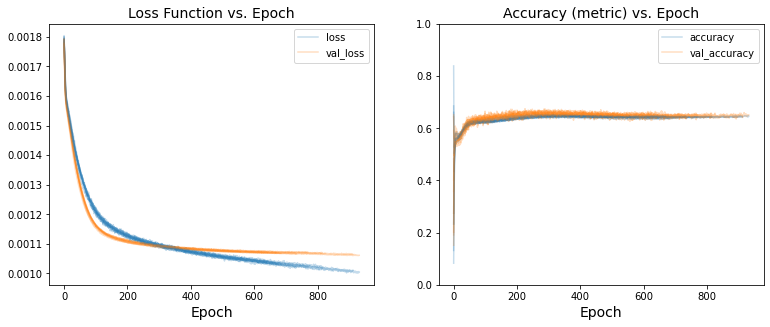

In [20]:
plt.figure(figsize=[2*6.4,1*4.8])

for i in range(n_models):
    
    this_NN = v_classifier[i]
    this_history = v_history[i]

    # Plot the significances with their error bars:
    ax = plt.subplot(1, 2, 1)
    # plt.figure()
    plt.title("Loss Function vs. Epoch", fontsize=14)
    plt.plot(this_history.history['loss'], alpha=0.25, color='C0')
    plt.plot(this_history.history['val_loss'], alpha=0.25, color='C1')
    plt.legend(['loss','val_loss'])
    plt.xlabel('Epoch', fontsize=14)
    # plt.ylabel('Loss', fontsize=14)
    
    # plt.yscale('log')

    ax = plt.subplot(1, 2, 2)
    # plt.figure()
    plt.title("Accuracy (metric) vs. Epoch", fontsize=14)
    plt.plot(this_history.history['accuracy'], alpha=0.25, color='C0')
    plt.plot(this_history.history['val_accuracy'], alpha=0.25, color='C1')
    plt.legend(['accuracy','val_accuracy'])
    plt.xlabel('Epoch', fontsize=14)
    plt.ylim([0,1])
    # plt.ylabel('Accuracy', fontsize=14)

plt.savefig('plots/loss_accuracy_{}.pdf'.format(name))
plt.show()

Add some variables

In [21]:
pred_columns = [c for c in x_test_results if c.startswith('pred')]
x_test_results['mean_pred'] = np.mean(x_test_results[pred_columns], axis=1)
x_test_results['is_signal'] = y_test
# Add the real weights back:
x_test_results['wgt'] = np.array(wgt_test)
x_test_results['SR'] = np.array(SR_test)
x_test_results['y'] = np.array(y_test)

x_train_results = x_train.copy()
x_train_results['pred'] = classifier.predict(x_train, batch_size=10000)
x_train_results['wgt'] = np.array(wgt_train) # wgt_train preserves the original weights, and shuffled
x_train_results['SR'] = np.array(SR_train)
x_train_results['y'] = np.array(y_train)

Plot yield vs NN output

# Normalized signal / background plot

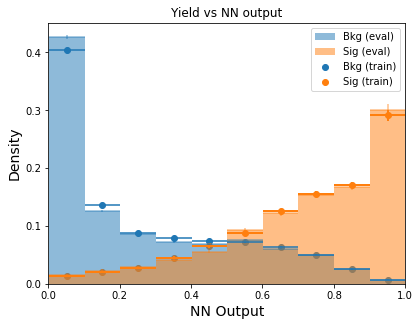

In [22]:
plt.figure(figsize=[1*6.4,1*4.8])

# BACKGROUND
# plt.subplot(1,2,1)
plt.title("Yield vs NN output")

n_bg_test = sum(wgt_test[y_test == 0])
n_bg_train = sum(wgt_train[y_train == 0])

n, b, _ = plt.hist(x_test_results[y_test == 0].mean_pred, bins=10, alpha=0.5, label='Bkg (eval)', 
                   weights = wgt_test[y_test == 0]/n_bg_test)
bin_centers = (b[:-1]+b[1:])/2
train_bg_bin_y = np.histogram(x_train_results[y_train == 0].pred, bins=b, 
                              weights = wgt_train[y_train == 0]/n_bg_train)[0]
scatter = plt.scatter(bin_centers, train_bg_bin_y, label='Bkg (train)')
# to plot error bars:
sumw2 = np.histogram(x_test_results[y_test == 0].mean_pred, bins=b, 
                              weights = (wgt_test[y_test == 0]/n_bg_test)**2)[0]
bin_widths  = (b[1:]-b[:-1])/2
plt.errorbar(x=bin_centers, y=n, xerr=bin_widths, yerr=np.sqrt(sumw2), fmt=' ', color='C0', alpha=0.5)
# to plot error bars:
sumw2 = np.histogram(x_train_results[y_train == 0].pred, bins=b, 
                              weights = (wgt_train[y_train == 0]/n_bg_train)**2)[0]
bin_widths  = (b[1:]-b[:-1])/2
plt.errorbar(x=bin_centers, y=scatter.get_offsets().data[:,1], xerr=bin_widths, yerr=np.sqrt(sumw2), fmt=' ', color='C0')


plt.xlabel('NN Output', fontsize=14)
plt.ylabel('Yield', fontsize=14)
plt.xlim([0,1])
plt.legend()

# USING N(ENTRIES):
# ax = plt.subplot(1,2,2)
# plt.title("Signal Yield vs NN output")

n_sig_test = sum(wgt_test[y_test == 1])
n_sig_train = sum(wgt_train[y_train == 1])

n, b, _ = plt.hist(x_test_results[y_test == 1].mean_pred, bins=b, alpha=0.5, label='Sig (eval)', 
                   weights = wgt_test[y_test == 1]/n_sig_test, color='C1', linewidth=0)
bin_centers = (b[:-1]+b[1:])/2
train_sig_bin_y = np.histogram(x_train_results[y_train == 1].pred, bins=b, 
                              weights = wgt_train[y_train == 1]/n_sig_train)[0]
scatter = plt.scatter(bin_centers, train_sig_bin_y, label='Sig (train)', color='C1')
# to plot error bars:
sumw2 = np.histogram(x_test_results[y_test == 1].mean_pred, bins=b, 
                              weights = (wgt_test[y_test == 1]/n_sig_test)**2)[0]
bin_widths  = (b[1:]-b[:-1])/2
plt.errorbar(x=bin_centers, y=n, xerr=bin_widths, yerr=np.sqrt(sumw2), fmt=' ', color='C1', alpha=0.5)
# to plot error bars:
sumw2 = np.histogram(x_train_results[y_train == 1].pred, bins=b, 
                              weights = (wgt_train[y_train == 1]/n_sig_train)**2)[0]
plt.errorbar(x=bin_centers, y=scatter.get_offsets().data[:,1], xerr=bin_widths, yerr=np.sqrt(sumw2), 
             fmt=' ', color='C1', linewidth=2)

plt.xlabel('NN Output', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.xlim([0,1])
plt.legend()

# plt.yscale('log')

# plt.savefig('plots/plot1_together_{}.pdf'.format(name))
plt.savefig('plots/plot1_together_normalized_{}.pdf'.format(name))
# plt.savefig('plots/plot1_together_normalized_log_{}.pdf'.format(name))

# plt.savefig('plots/2021-12-11_batch_' + str(batch_size) + '.pdf')
plt.show()

In [23]:
print(sum(wgt_test[y_test == 0]))
print(sum(wgt_train[y_train == 0]))

print(sum(wgt_test[y_test == 1]))
print(sum(wgt_train[y_train == 1]))

537.708742489713
532.1157503523295
2.650062243674149
2.613323018110252


0.822321235447934


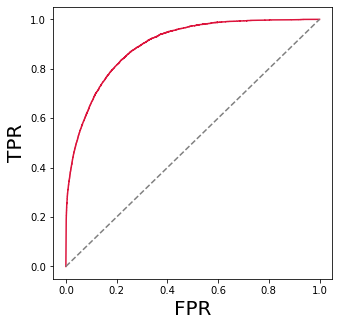

In [24]:
plt.figure(figsize=(5, 5))

# for c in ['pred_0', 'mean_pred']:
#     fpr, tpr, _ = roc_curve(y_test, x_test_results[c], sample_weight=w_test)

#     plt.plot(fpr, tpr)
    
for c in ['mean_pred']:
    fpr, tpr, _ = roc_curve(y_test, x_test_results[c], sample_weight=w_test)

    plt.plot(fpr, tpr, ls='-', color='crimson')
        
plt.plot([0, 1], [0, 1], ls='--', color='grey')
plt.xlabel('FPR', fontsize=20)
plt.ylabel('TPR', fontsize=20)
plt.savefig('plots/ROC_{}.pdf'.format(name))

print(sum(tpr)/len(fpr))

plt.show()

# Finder of best cut in each signal region

In [30]:
print('Finding the best NN cut in each separate signal region:')
print()


best_significances = []
best_cuts = []

# for plotting:
list_cuts = [[],[],[]]
list_significances = [[],[],[]]
list_significance_errors = [[],[],[]]
list_signal_yields = [[],[],[]]
list_signal_yield_errors = [[],[],[]]
list_background_yields = [[],[],[]]
list_background_yield_errors = [[],[],[]]

for i in [0,1,2]:
    
    if (i==0): 
        print("---- In the region SF-inZ ----")
    if (i==1): 
        print("---- In the region SF-noZ ----")
    if (i==2): 
        print("---- In the region DF ----")
        
    best_cut = 0
    maximum_significance = 0
    maximum_significance_error = 0
    best_S = 0
    best_dS = 0
    best_B = 0
    best_dB = 0

    data_passed_cut = x_test_results[x_test_results.SR==i]

    for x in np.linspace(0,0.99,200):
        cut = x
        data_passed_cut = data_passed_cut[data_passed_cut.mean_pred >= cut]
        sig_passed_cut = data_passed_cut[data_passed_cut.is_signal == 1]
        bg_passed_cut = data_passed_cut[data_passed_cut.is_signal == 0]

        n_sig_passed_cut = sum(sig_passed_cut.wgt)
        n_bg_passed_cut = sum(bg_passed_cut.wgt)

        S, dS  = yield_and_error(sig_passed_cut)
        B, dB  = yield_and_error(bg_passed_cut)
            
        if (S<0.25):
            continue
        if (B<0):
            print(B)
            continue
        significance, error = significance_and_error(S, dS, B, dB)
        
        list_cuts[i].append(cut)
        list_significances[i].append(significance)
        list_significance_errors[i].append(error)
        list_signal_yields[i].append(S)
        list_signal_yield_errors[i].append(dS)
        list_background_yields[i].append(B)
        list_background_yield_errors[i].append(dB)
        
        if (cut == 0):
            print('Original yields:')
            print(' S: %.2f ± %.2f events'%(S,dS))
            print(' B: %.2f ± %.2f events'%(B,dB))
            print(' Significance = %.2f ± %.2f'%(significance, error))
            print()

        if ((S+B)>=(10/4)):
            if (significance > maximum_significance):
                best_cut = cut
                maximum_significance = significance
                maximum_significance_error = error
                best_S = S
                best_dS = dS
                best_B = B
                best_dB = dB
            
    best_significances.append((maximum_significance, maximum_significance_error))
    best_cuts.append(best_cut)

    print('Best NN cut: %.3f'%(best_cut))
    print('New yields:')
    print(' S: %.2f ± %.2f events'%(best_S,best_dS))
    print(' B: %.2f ± %.2f events'%(best_B,best_dB))
    print(' Significance = %.2f ± %.2f'%(maximum_significance, maximum_significance_error))
    print("------------------------------")
    print()
    
    
print("---- In quadrature ----")


temporal = []

for i in [0,1,2]:
    maximum_significance = 0
    maximum_significance_error = 0
    best_S = 0
    best_dS = 0
    best_B = 0
    best_dB = 0

    data_passed_cut = x_test_results[x_test_results.SR==i]
    sig_passed_cut = data_passed_cut[data_passed_cut.is_signal == 1]
    bg_passed_cut = data_passed_cut[data_passed_cut.is_signal == 0]

    S, dS  = yield_and_error(sig_passed_cut)
    B, dB  = yield_and_error(bg_passed_cut)
    
    temporal.append((significance_and_error(S, dS, B, dB)))

old_quad, old_quad_error = add_in_quadrature_3(temporal[0], temporal[1], temporal[2]) 
print("Old significance = {:.2f} ± {:.2f} ".format(old_quad, old_quad_error))

best_quad, best_quad_error = add_in_quadrature_3(best_significances[0], best_significances[1], best_significances[2]) 
print("Best significance = {:.2f} ± {:.2f} ".format(best_quad, best_quad_error))

Finding the best NN cut in each separate signal region:

---- In the region SF-inZ ----
Original yields:
 S: 2.65 ± 0.03 events
 B: 537.71 ± 2.42 events
 Significance = 0.11 ± 0.00

Best NN cut: 0.935
New yields:
 S: 0.65 ± 0.02 events
 B: 1.86 ± 0.13 events
 Significance = 0.45 ± 0.02
------------------------------

---- In the region SF-noZ ----
Best NN cut: 0.000
New yields:
 S: 0.00 ± 0.00 events
 B: 0.00 ± 0.00 events
 Significance = 0.00 ± 0.00
------------------------------

---- In the region DF ----
Best NN cut: 0.000
New yields:
 S: 0.00 ± 0.00 events
 B: 0.00 ± 0.00 events
 Significance = 0.00 ± 0.00
------------------------------

---- In quadrature ----
Old significance = 0.11 ± 0.00 
Best significance = 0.45 ± 0.02 


# END

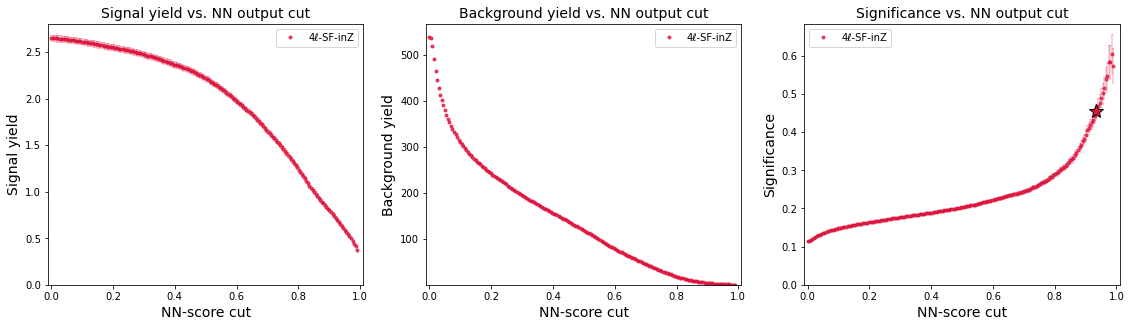

In [40]:
plt.figure(figsize=[3*6.4,1*4.8])

# Plot the significances with their error bars:
ax = plt.subplot(1, 3, 3)
# plt.figure(figsize=[1.5*6.4,1.5*4.8])
plt.title('Significance vs. NN output cut', fontsize=14)
plt.xlabel('NN-score cut', fontsize=14)
plt.ylabel('Significance', fontsize=14)
plt.errorbar(list_cuts[0], list_significances[0], yerr=list_significance_errors[0], 
             fmt=' ', capsize=1, color='crimson', alpha=0.25)
plt.plot(list_cuts[0],list_significances[0], 'o', markersize = 3, color='crimson', alpha=0.75)
plt.legend(['4ℓ-SF-inZ'])
# Plot the maximums:
plt.plot(best_cuts[0], best_significances[0][0],'*', color='crimson', fillstyle='full', 
         markeredgecolor='black', markersize=15)
plt.ylim(0)
plt.xlim([-0.01,1.01])
# plt.savefig('20211201.pdf')
# plt.show()

# Plot the signal yields with their error bars:
ax = plt.subplot(1, 3, 1)
# plt.figure(figsize=[1.5*6.4,1.5*4.8])
plt.title('Signal yield vs. NN output cut', fontsize=14)
plt.xlabel('NN-score cut', fontsize=14)
plt.ylabel('Signal yield', fontsize=14)
plt.errorbar(list_cuts[0], list_signal_yields[0], yerr=list_signal_yield_errors[0], 
             fmt=' ', capsize=1, color='crimson', alpha=0.25)
plt.plot(list_cuts[0],list_signal_yields[0], 'o', markersize = 3, color='crimson', alpha=0.75)
plt.ylim(0)
plt.xlim([-0.01,1.01])
plt.legend(['4ℓ-SF-inZ'])

# Plot the background yields with their error bars:
ax = plt.subplot(1, 3, 2)
# plt.figure(figsize=[1.5*6.4,1.5*4.8])
plt.title('Background yield vs. NN output cut', fontsize=14)
plt.xlabel('NN-score cut', fontsize=14)
plt.ylabel('Background yield', fontsize=14)
plt.errorbar(list_cuts[0], list_background_yields[0], yerr=list_background_yield_errors[0], 
             fmt=' ', capsize=1, color='crimson', alpha=0.25)
plt.plot(list_cuts[0],list_background_yields[0], 'o', markersize = 3, color='crimson', alpha=0.75)
plt.ylim(0.0001)
plt.xlim([-0.01,1.01])
# plt.yscale('log')
plt.legend(['4ℓ-SF-inZ'])

plt.savefig('plots/x_plot2_{}.pdf'.format(name))
plt.show()

## Plot weight distribution in some samples separated by physics process

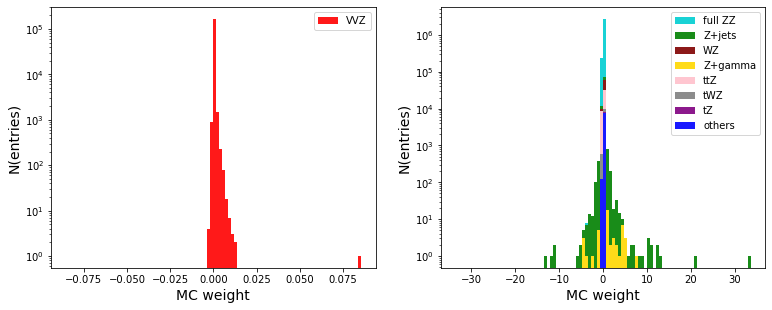

In [67]:
VVZ     = pd.read_feather('/home/grabanal/minitree/20211129_no_iso_VVZ.arrow')
ZZ       = pd.read_feather('/home/grabanal/minitree/20211129_no_iso_ZZ.arrow')
WZ       = pd.read_feather('/home/grabanal/minitree/20211129_no_iso_WZ.arrow')
Zjets_new  = pd.read_feather('/home/grabanal/minitree/20211129_no_iso_Zjets.arrow')
Zgamma = pd.read_feather('/home/grabanal/minitree/20211129_no_iso_Zgamma.arrow')
ttZ    = pd.read_feather('/home/grabanal/minitree/20211129_no_iso_ttZ.arrow')
tZ     = pd.read_feather('/home/grabanal/minitree/20211129_no_iso_tZ.arrow')
tWZ    = pd.read_feather('/home/grabanal/minitree/20211129_no_iso_tWZ.arrow')
others = pd.read_feather('/home/grabanal/minitree/20211129_no_iso_others.arrow')
FULLBG = pd.read_feather('/home/grabanal/minitree/20211129_no_iso_FULLBG.arrow')

# VVZ     = pd.read_feather('/home/grabanal/minitree/20211129_iso_e4m1_VVZ.arrow')
# ZZ       = pd.read_feather('/home/grabanal/minitree/20211129_iso_e4m1_ZZ.arrow')
# WZ       = pd.read_feather('/home/grabanal/minitree/20211129_iso_e4m1_WZ.arrow')
# Zjets_new  = pd.read_feather('/home/grabanal/minitree/20211129_iso_e4m1_Zjets.arrow')
# Zgamma = pd.read_feather('/home/grabanal/minitree/20211129_iso_e4m1_Zgamma.arrow')
# ttZ    = pd.read_feather('/home/grabanal/minitree/20211129_iso_e4m1_ttZ.arrow')
# tZ     = pd.read_feather('/home/grabanal/minitree/20211129_iso_e4m1_tZ.arrow')
# tWZ    = pd.read_feather('/home/grabanal/minitree/20211129_iso_e4m1_tWZ.arrow')
# others = pd.read_feather('/home/grabanal/minitree/20211129_iso_e4m1_others.arrow')
# FULLBG = pd.read_feather('/home/grabanal/minitree/20211129_iso_e4m1_FULLBG.arrow')


individual_backgrounds = [ZZ, WZ, Zjets_new, Zgamma, ttZ, tZ, tWZ, others]

order = [others, tZ, tWZ, ttZ, Zgamma, WZ, Zjets_new, ZZ]


plt.figure(figsize=[2*6.4,1*4.8])
variable, denom, my_range, my_bins = 'wgt', 1, (-30,30), 100
my_alpha = 0.9



ax = plt.subplot(1, 2, 1)
plt.xlabel('MC weight', fontsize=14)
plt.ylabel('N(entries)', fontsize=14)
max_wgt = np.maximum( abs(np.min(VVZ['wgt'])), np.max(VVZ['wgt']) ) 
my_range = (-max_wgt,max_wgt)
n, bins, patches = plt.hist(VVZ[variable]/denom, range=my_range,
                            bins=my_bins, alpha=my_alpha, color='red', label='VVZ')
ax.legend(['VVZ'])
plt.yscale('log')
    

    
ax = plt.subplot(1, 2, 2)
plt.xlabel('MC weight', fontsize=14)
plt.ylabel('N(entries)', fontsize=14)
colors = ('blue','purple','grey','pink', 'gold', 'maroon','green','darkturquoise')
labels = ('others', 'tZ', 'tWZ', 'ttZ', 'Z+gamma', 'WZ', 'Z+jets', 'full ZZ')
max_wgt = np.maximum( abs(np.min(FULLBG['wgt'])), np.max(FULLBG['wgt']) ) 
my_range = (-max_wgt,max_wgt)
n, bins, patches = plt.hist( (order[0][variable]/denom, 
                             order[1][variable]/denom,
                             order[2][variable]/denom,
                             order[3][variable]/denom,
                             order[4][variable]/denom,
                             order[5][variable]/denom,
                             order[6][variable]/denom,
                             order[7][variable]/denom),
                            range=my_range, 
                            bins=my_bins, alpha=my_alpha, 
                            color=colors, label=labels, stacked=True)
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), loc='best')
plt.yscale('log')

plt.savefig('plots/this.pdf')
plt.show()

In [46]:
max_wgt = np.maximum( abs(np.min(FULLBG['wgt'])), np.max(FULLBG['wgt']) )
max_wgt

33.633478207783135

In [47]:
abs(np.min(FULLBG['wgt']))

12.864305480738405

In [48]:
np.max(FULLBG['wgt'])

33.633478207783135

 end of notebook

# Test of Keras tuner

In [273]:
# Fit ML classifier
EPOCHS = 1000
batch_size = 1000
num_nodes = 64 # where is this used?
dropout = 0.1
# learning_rate = 

n_models = 1

x_test_results = x_test.copy()

def model_builder(hp):
    
#     model = keras.Sequential()
#     model.add(keras.layers.Flatten(input_shape=(28, 28)))

#     # Tune the number of units in the first Dense layer
#     # Choose an optimal value between 32-512
#     hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
#     model.add(keras.layers.Dense(units=hp_units, activation='relu'))
#     model.add(keras.layers.Dense(10))

#     # Tune the learning rate for the optimizer
#     # Choose an optimal value from 0.01, 0.001, or 0.0001
#     hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

#     model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
#                 loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#                 metrics=['accuracy'])

#     return model

    classifier = Sequential()
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    hp_units_1 = hp.Int('units_1', min_value=10, max_value=100, step=10)
    classifier.add(Dense(units=hp_units_1, input_dim=x_train.shape[1], activation='relu')) 
    classifier.add(Dropout(dropout))
    hp_units_2 = hp.Int('units_2', min_value=10, max_value=100, step=10)
    classifier.add(Dense(units=hp_units_2, activation='relu'))
    classifier.add(Dropout(dropout))
    hp_units_3 = hp.Int('units_3', min_value=10, max_value=100, step=10)
    classifier.add(Dense(units=hp_units_3, activation='relu'))
    classifier.add(Dropout(dropout))
#     hp_units_4 = hp.Int('units_4', min_value=2, max_value=2, step=1)
#     classifier.add(Dense(units=hp_units_4, activation='relu'))
#     classifier.add(Dropout(dropout))
    classifier.add(Dense(1, activation='sigmoid'))
    classifier.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # Early stopping
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)

#     history = classifier.fit(x_train, y_train, epochs=EPOCHS, batch_size=batch_size,
#                              validation_data=(x_test, y_test, w_test), sample_weight=w_train, 
#                              verbose=1, callbacks=[callback])
    
#     x_test_results['pred_' + str(i)] = classifier.predict(x_test, batch_size=batch_size)
    return classifier

In [275]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt_0',
                    hyperband_iterations=1)

In [276]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [277]:
tuner.search(x_train, y_train, epochs=EPOCHS, batch_size=batch_size, 
             validation_data=(x_test, y_test, w_test), sample_weight=w_train, 
             verbose=1, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete.
The optimal number of units in dense layer 1 is {best_hps.get('units_1')}, 
The optimal number of units in dense layer 2 is {best_hps.get('units_2')},
The optimal number of units in dense layer 3 is {best_hps.get('units_3')}
""")

Trial 30 Complete [00h 00m 25s]
val_accuracy: 0.6669543385505676

Best val_accuracy So Far: 0.7773230075836182
Total elapsed time: 00h 05m 24s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete.
The optimal number of units in dense layer 1 is 100, 
The optimal number of units in dense layer 2 is 100,
The optimal number of units in dense layer 3 is 50



In [ ]:
model = tuner.hypermodel.build(best_hps)